In the previous post, I showed how to integrate Hamiltonian systems

$$\begin{align}
\dot q & = +\frac{\partial H}{\partial p} \\
\dot p & = -\frac{\partial H}{\partial q}
\end{align}$$

using methods that approximately preserve the energy.
Here I'd like to look at what happens when there are non-trivial constraints

$$g(q) = 0$$

on the configuration of the system.
The simplest example is the pendulum problem, where the position $x$ of the pendulum is constrained to lie on the circle of radius $L$ centered at the origin.
These constraints are easy to eliminate by instead working with the angle $\theta$.
A more complicated example is a problem with rotational degrees of freedom, where the angular configuration $Q$ is a 3 $\times$ 3 matrix.
The constraint comes from the fact that this matrix has to be orthogonal:

$$Q^\top Q = I.$$

We could play similar tricks to the case of the pendulum and use [Euler angles](https://en.wikipedia.org/wiki/Euler_angles), but these introduce [other problems](https://en.wikipedia.org/wiki/Gimbal_lock#Loss_of_a_degree_of_freedom_with_Euler_angles) when used for numerics.
For this or other more complex problems, we'll instead enforce the constraints using a Lagrange multiplier $\lambda$, and working with the constrained Hamiltonian

$$H' = H - \lambda\cdot g(q).$$

We're then left with a differential-algebraic equation:

$$\begin{align}
\dot q & = +\frac{\partial H}{\partial p} \\
\dot p & = -\frac{\partial H}{\partial q} + \lambda\cdot\nabla g \\
0 & = g(q).
\end{align}$$

If you feel like I pulled this multiplier trick out of a hat, you might find it more illuminating to think back to the [Lagrangian](https://en.wikipedia.org/wiki/Lagrangian_mechanics#Lagrange_multipliers_and_constraints) formulation of mechanics, which corresponds more directly with optimization via the stationary action principle.
Alternatively, you can view the Hamiltonian above as the limit of

$$H_\epsilon' = H + \frac{|p_\lambda|^2}{2\epsilon} - \lambda\cdot g(q)$$

as $\epsilon \to 0$, where $p_\lambda$ is a momentum variable conjugate to $\lambda$.
This zero-mass limit is a [singular perturbation](https://en.wikipedia.org/wiki/Singular_perturbation), so actually building a practical algorithm from this formulation is pretty awful, but it can be pretty helpful conceptually.

For now we'll assume that the Hamiltonian has the form

$$H = \frac{1}{2}p^*M^{-1}p + U(q)$$

for some mass matrix $M$ and potential energy $U$.
The 2nd-order splitting scheme to solve Hamilton's equations of motion in the absence of any constraints are

$$\begin{align}
p_{n + \frac{1}{2}} & = p_n - \frac{\delta t}{2}\nabla U(q_n) \\
q_{n + 1} & = q_n + \delta t\cdot M^{-1}p_{n + \frac{1}{2}} \\
p_{n + 1} & = p_{n + \frac{1}{2}} - \frac{\delta t}{2}\nabla U(q_{n + 1}).
\end{align}$$

To enforce the constraints, we'll add some extra steps where we project back onto the surface or, in the case of the momenta, onto its cotangent space.
In the first stage, we solve the system

$$\begin{align}
p_{n + \frac{1}{2}} & = p_n - \frac{\delta t}{2}\left\{\nabla U(q_n) - \lambda_{n + 1}\cdot \nabla g(q_n)\right\} \\
q_{n + 1} & = q_n - \delta t\cdot M^{-1}p_{n + \frac{1}{2}} \\
0 & = g(q_{n + 1}).
\end{align}$$

If we substitute the formula for $p_{n + 1/2}$ into the second equation and then substitute the resulting formula for $q_{n + 1}$ into the constraint $0 = g(q_{n + 1})$, we get a nonlinear system of equations for the new Lagrange multiplier $\lambda_{n + 1}$ purely in terms of the current positions and momenta.
Having solved this nonlinear system, we can then substitute the value of $\lambda_{n + 1}$ to obtain the values of $p_{n + 1/2}$ and $q_{n + 1}$.
Next, we compute the momentum at step $n + 1$, but subject to the constraint that it has to lie in the cotangent space of the surface:

$$\begin{align}
p_{n + 1} & = p_{n + \frac{1}{2}} - \frac{\delta t}{2}\left\{\nabla U(q_{n + 1}) - \mu_{n + 1}\cdot \nabla g(q_{n + 1})\right\} \\
0 & = \nabla g(q_{n + 1})\cdot M^{-1}p_{n + 1}.
\end{align}$$

Once again, we can substitute the first equation into the second to obtain a linear system for the momentum-space multiplier $\mu$.
Having solved for $\mu$, we can then back-substitute into the first equation to get $p_{n + 1}$.
This is the RATTLE algorithm.
(I'm pulling heavily from chapter 7 of [Leimkuhler and Reich](https://doi.org/10.1017/CBO9780511614118) here if you want to see a comparison with other methods and proofs that it's symplectic.)



### Surfaces

Next we have to pick an example problem to work on.
To start out, we'll assume that the potential energy for the problem is 0 and focus solely on the free motion of a particle on some interesting surface.
The simplest surface we could look at is the sphere:

$$g(x, y, z) = x^2 + y^2 + z^2 - R^2$$

or the torus:

$$g(x, y, z) = \left(\sqrt{x^2 + y^2} - R\right)^2 + z^2 - r^2.$$

Just for kicks, I'd like to instead look at motion on surfaces of genus 2 or higher.
There are simple parametric equations for tracing out spheres and tori in terms of the trigonometric functions, so the machinery of explicitly enforcing constraints isn't really necessary.
There is no such direct parameterization for higher-genus surfaces, so we'll actually need to be clever in defining the surface and in simulating motion on it.
As an added bonus, the ability to trace out curves on the surface will give us a nice way of visualizing it.

To come up with an implicit equation for a higher-genus surface, we'll start with an implicit equation for a 2D curve and inflate it into 3D.
For example, the equation for the torus that we defined above is obtained by inflating the implicit equation $\sqrt{x^2 + y^2} - R = 0$ for the circle in 2D.
What we want to generate higher-genus surfaces is a *lemniscate*.
An ellipse is defined as the set of points such that the sum of the distances to two foci is constant.
Likewise, a lemniscate is defined as the set of points such that the *product* of the distances to two or more foci is constant.
The [Bernoulli leminscate](https://en.wikipedia.org/wiki/Lemniscate_of_Bernoulli) is one such example, which traces out a figure-8 in 2D.
The Bernoulli leminscate is the zero set of the polynomial

$$f(x, y) = (x^2 + y^2)^2 - a^2(x^2 - y^2)$$

and it also has the parametric equation

$$\begin{align}
x & = a\frac{\sin t}{1 + \cos^2t} \\
y & = a\frac{\sin t\cdot\cos t}{1 + \cos^2t}
\end{align}$$

which gives us a simple way to visualize what we're starting with.

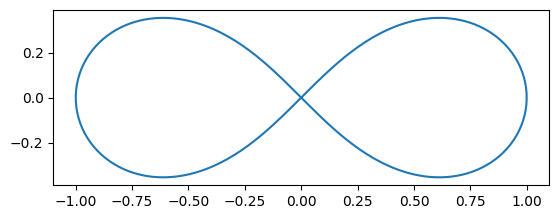

In [1]:
import numpy as np
from numpy import pi as π

a = 1
t = np.linspace(0, 2 * π, 256)
xs = a * np.sin(t) / (1 + np.cos(t) ** 2)
ys = a * np.sin(t) * np.cos(t) / (1 + np.cos(t) ** 2)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.plot(xs, ys);

We've loosely referred to the idea of inflating the zero-contour of a function $f(x, y)$ into 3D.
The 3D function defining the desired implicit surface is

$$g(x, y, z) = f(x, y)^2 + z^2 - r^2,$$

where $r$ is a free parameter that we'll have to tune.
I'm going to guess that $r < \frac{a}{\sqrt{2}}$ but it could be much less; beyond that we'll have to figure out what $r$ is by trial and error.

The code below uses the [sympy](https://www.sympy.org/) software package to create a symbolic representation of the function $g$ defining our surface.
Having a symbolic expression for $g$ allows us to evaluate it and its derivatives, but to actually visualize the surface we'll have to sample points on it somehow.

In [2]:
import sympy
x, y, z = sympy.symbols("x y z")
f = (x ** 2 + y ** 2) ** 2 - a ** 2 * (x ** 2 - y ** 2)

r = a / 6
g = f ** 2 + z ** 2 - r **2
dg = sympy.derive_by_array(g, [x, y, z])

Symbolically evaluating $g$ every time is expensive, so the code below uses the `lambdify` function from sympy to convert our symbolic expression into an ordinary Python function.
I've added some additional wrappers so that we can pass in a numpy array of coordinates rather than the $x$, $y$, and $z$ values as separate arguments.

In [3]:
g_fn = sympy.lambdify([x, y, z], g, modules="numpy")
def G(q):
    return np.array([g_fn(*q)])

dg_fn = sympy.lambdify([x, y, z], dg, modules="numpy")
def dG(q):
    return np.array(dg_fn(*q)).reshape([1, 3])

One of the first algorithms for constrained mechanical systems was called SHAKE, so naturally some clever bastard had to make one called RATTLE and there's probably a ROLL out there too.
The code below implements the RATTLE algorithm.
You can view this as analogous to the Stormer-Verlet method, which does a half-step of the momentum solve, a full step of the position solve, and finally another half-step of the momentum solve again.
In the RATTLE algorithm, we have to exercise a bit of foresight in the initial momentum half-step and position full-step in order to calculate a Lagrange multiplier to project an arbitrary position back onto the zero-contour of $g$.
Solving for the position multiplier is a true nonlinear equation, whereas the final momentum half-step is just a linear equation for the momentum and its multiplier, which we've written here as $\mu$.
Here we only have one constraint, so each multiplier is a scalar, which is a convenient simplification.

In [4]:
import tqdm
import scipy.linalg
import scipy.optimize

def trajectory(q, v, dt, num_steps, f, g, dg, progressbar=False):
    qs = np.zeros((num_steps + 1,) + q.shape)
    vs = np.zeros((num_steps + 1,) + q.shape)

    g_0 = g(q)
    λs = np.zeros((num_steps + 1,) + g_0.shape)
    μs = np.zeros((num_steps + 1,) + g_0.shape)

    def project_position(λ_0, q, v):
        def fn(λ, q, v):
            v_n = v + 0.5 * dt * (f(q) - λ @ dg(q))
            q_n = q + dt * v_n
            return g(q_n)

        result = scipy.optimize.root(fn, λ_0, args=(q, v))
        return result.x

    def project_velocity(q, v):
        J = dg(q)
        # TODO: Don't solve the normal equations, you're making Anne G sad
        A = J @ J.T
        b = J @ v
        return scipy.linalg.solve(A, b, assume_a="pos")

    qs[0] = q
    μs[0] = project_velocity(q, v)
    vs[0] = v - μs[0] @ dg(q)

    iterator = (tqdm.trange if progressbar else range)(num_steps)
    for t in iterator:
        λs[t + 1] = project_position(λs[t], qs[t], vs[t])
        v_mid = vs[t] + 0.5 * dt * (f(qs[t]) - λs[t + 1] @ dg(qs[t]))
        qs[t + 1] = qs[t] + dt * v_mid

        v_prop = v_mid + 0.5 * dt * f(qs[t + 1])
        μs[t + 1] = project_velocity(qs[t + 1], v_prop)
        vs[t + 1] = v_mid + 0.5 * dt * f(qs[t + 1]) - μs[t + 1] @ dg(qs[t + 1])

    return qs, vs, λs, μs

I'll add that this algorithm was exceedingly fiddly to implement and I had to debug about 5 or 6 times before I got it right.
The sanity checking shown below was essential to making sure it was right.

In [5]:
def potential(q):
    return q[2]

def force(q):
    return np.array((0, 0, -1))

In [6]:
num_trajectories = 25
θs = 2 * π * np.linspace(0, 1, num_trajectories)
num_steps = 2000
Qs = np.zeros((num_steps + 1, 3 * num_trajectories))
Vs = np.zeros((num_steps + 1, 3 * num_trajectories))
Λs = np.zeros((num_steps + 1, num_trajectories))
for i, θ in tqdm.tqdm(enumerate(θs), total=num_trajectories):
    q = np.array((0, 0, r))
    v = np.array((np.cos(θ), np.sin(θ), 0))
    dt = 1e-2
    qs, vs, λs, μs = trajectory(q, v, dt, num_steps, force, G, dG)
    Qs[:, 3 * i : 3 * (i + 1)] = qs
    Vs[:, 3 * i : 3 * (i + 1)] = vs
    Λs[:, i] = λs.flatten()

  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:00<00:16,  1.49it/s]

  8%|▊         | 2/25 [00:01<00:15,  1.46it/s]

 12%|█▏        | 3/25 [00:02<00:15,  1.40it/s]

 16%|█▌        | 4/25 [00:02<00:15,  1.37it/s]

 20%|██        | 5/25 [00:03<00:14,  1.38it/s]

 24%|██▍       | 6/25 [00:04<00:13,  1.40it/s]

 28%|██▊       | 7/25 [00:04<00:12,  1.43it/s]

 32%|███▏      | 8/25 [00:05<00:11,  1.44it/s]

 36%|███▌      | 9/25 [00:06<00:11,  1.40it/s]

 40%|████      | 10/25 [00:07<00:10,  1.37it/s]

 44%|████▍     | 11/25 [00:07<00:10,  1.35it/s]

 48%|████▊     | 12/25 [00:08<00:09,  1.33it/s]

 52%|█████▏    | 13/25 [00:09<00:08,  1.34it/s]

 56%|█████▌    | 14/25 [00:10<00:08,  1.37it/s]

 60%|██████    | 15/25 [00:10<00:07,  1.37it/s]

 64%|██████▍   | 16/25 [00:11<00:06,  1.38it/s]

 68%|██████▊   | 17/25 [00:12<00:05,  1.40it/s]

 72%|███████▏  | 18/25 [00:12<00:04,  1.41it/s]

 76%|███████▌  | 19/25 [00:13<00:04,  1.44it/s]

 80%|████████  | 20/25 [00:14<00:03,  1.44it/s]

 84%|████████▍ | 21/25 [00:14<00:02,  1.45it/s]

 88%|████████▊ | 22/25 [00:15<00:02,  1.45it/s]

 92%|█████████▏| 23/25 [00:16<00:01,  1.44it/s]

 96%|█████████▌| 24/25 [00:17<00:00,  1.44it/s]

100%|██████████| 25/25 [00:17<00:00,  1.42it/s]

100%|██████████| 25/25 [00:17<00:00,  1.40it/s]

As a sanity check, we'll evaluate the change in energy throughout the course of the simulation relative to the mean kinetic energy.
The relative differences are on the order of 1%, which suggests that the method is doing a pretty good job.
I re-ran this notebook with half the timestep and the energy deviation is cut by a factor of four, indicative of second-order convergence.

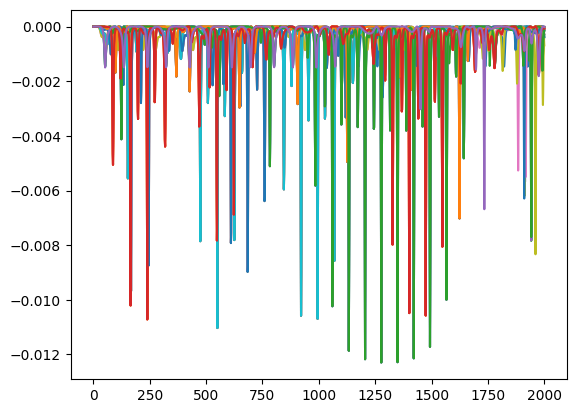

In [7]:
fig, ax = plt.subplots()
for i in range(num_trajectories):
    qs, vs = Qs[:, 3 * i : 3 * (i + 1)], Vs[:, 3 * i : 3 * (i + 1)]
    K = 0.5 * np.sum(vs ** 2, axis=1)
    U = np.array([potential(q) for q in qs])
    energies = K + U
    ax.plot((energies - energies[0]) / np.mean(K))

Finally, let's make a movie of the results.

In [8]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.animation import FuncAnimation


def make_animation(
    Qs, depth=25, duration=30.0, start_width=0.1, end_width=1.5, ax=None
):
    num_steps = Qs.shape[0]
    num_particles = Qs.shape[1] // 3

    widths = np.linspace(start_width, end_width, depth)
    collections = []
    for i in range(num_particles):
        q_i = Qs[:depth, 3 * i : 3 * (i + 1)]
        points = q_i.reshape(-1, 1, 3)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        collection = Line3DCollection(segments, linewidths=widths)
        collections.append(collection)
        ax.add_collection(collection)

    def update(step):
        start = max(0, step - depth)
        for i in range(num_particles):
            q_i = Qs[step - depth : step, 3 * i : 3 * (i + 1)]
            points = q_i.reshape(-1, 1, 3)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            collections[i].set_segments(segments)

    interval = 1e3 * duration / num_steps
    frames = list(range(depth, num_steps))
    return FuncAnimation(
        ax.figure, update, frames=frames, interval=interval, blit=False
    )

My Riemannian geometry kung fu is weak is but I think that the [geodesic flow](https://en.wikipedia.org/wiki/Geodesic#Flow) on this surface is [ergodic](https://en.wikipedia.org/wiki/Ergodicity) (see these [notes](http://math.uchicago.edu/~may/REU2019/REUPapers/Valva.pdf)).

In [9]:
%%capture

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.set_xlim((-a, a))
ax.set_ylim((-a, a))
ax.set_zlim((-a, a))
ax.set_axis_off()

animation = make_animation(Qs, depth=100, ax=ax)

In [10]:
from IPython.display import HTML
HTML(animation.to_html5_video())

It's also interesting to have a look at what the respective Lagrange multipliers for position and velocity are doing.

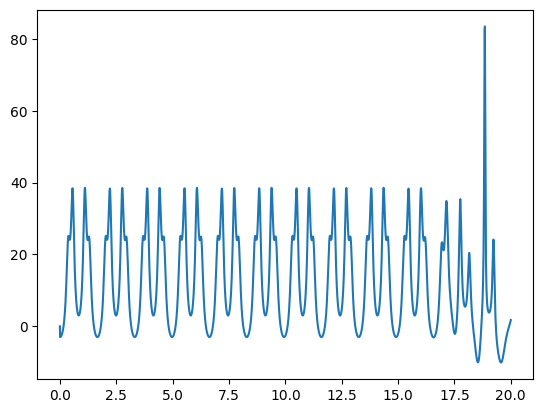

In [11]:
fig, ax = plt.subplots()
ts = np.linspace(0.0, num_steps * dt, num_steps + 1)
ax.plot(ts, Λs[:, 6].reshape(-1));

Note how the Lagrange multipliers aren't smooth -- they have pretty sharp transitions.
If you think of the Lagrange multipliers as fictitious "forces" that push the trajectories back onto the constraint manifold, then their amplitude is probably some kind of indicator of the local curvature of the constraint surface.

### More interesting now

This all worked well enough for a single particle on the surface.
Now let's see what happens if we put several particles on the surface and make them interact.
I'd like to find some potential that's repulsive at distances shorter than equilibrium, attractive at longer distances, and falls off to zero at infinity.
We could use the Lennard-Jones potential shown in the last demo but the singularity at the origin is going to create more difficulty than necessary.
Instead, I'll use a variant of the [Ricker wavelet](https://en.wikipedia.org/wiki/Ricker_wavelet), which is plotted below.

In [12]:
r_e = a / 6
U_e = 0.5
r = sympy.symbols("r")
ρ = r / r_e
potential = U_e / 2 * (1 - 3 * ρ ** 2) * sympy.exp(3 / 2 * (1 - ρ ** 2))

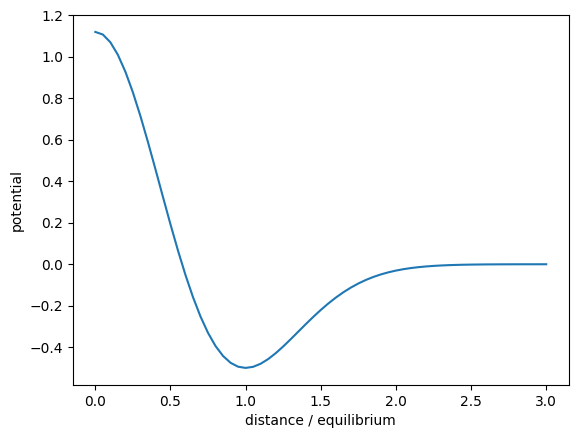

In [13]:
rs = np.linspace(0.0, 3 * r_e, 61)
Us = sympy.lambdify(r, potential, modules="numpy")(rs)

fig, ax = plt.subplots()
ax.set_xlabel("distance / equilibrium")
ax.set_ylabel("potential")
ax.plot(rs / r_e, Us);

I'm using this potential just because it's convenient -- no one thinks there are real particles that act like this.

Now that we're looking at a multi-particle system, we have to evaluate the constraint on every single particle.
The derivative matrix has a block structure which a serious implementation would take advantage of.

In [14]:
def G(q):
    return np.array([g_fn(*q[3 * i: 3 * (i + 1)]) for i in range(len(q) // 3)])

# TODO: Make it a sparse matrix
def dG(q):
    n = len(q) // 3
    J = np.zeros((n, 3 * n))
    for i in range(n):
        q_i = q[3 * i: 3 * (i + 1)]
        J[i, 3 * i: 3 * (i + 1)] = dg_fn(*q_i)

    return J

The code below calculates the total forces by summation over all pairs of particles.
I added this silly extra variable `force_over_r` to avoid any annoying singularities at zero distance.

In [15]:
force = sympy.diff(potential, r)
force_over_r = sympy.lambdify(r, sympy.simplify(force / r), modules="numpy")

def F(q):
    n = len(q) // 3
    f = np.zeros_like(q)
    for i in range(n):
        q_i = q[3 * i: 3 * (i + 1)]
        for j in range(i + 1, n):
            q_j = q[3 * j: 3 * (j + 1)]
            r_ij = q_i - q_j
            r = np.sqrt(np.inner(r_ij, r_ij))
            f_ij = force_over_r(r) * r_ij

            f[3 * i: 3 * (i + 1)] += f_ij
            f[3 * j: 3 * (j + 1)] -= f_ij

    return f

To initialize the system, we'll take every 100th point from one of the trajectories that we calculated above.

In [16]:
skip = 100
particle = 3
q = Qs[::skip, 3 * particle : 3 * (particle + 1)].flatten()
v = np.zeros_like(q)

In [17]:
dt = 1e-2
N = 2000
qs, vs, λs, μs = trajectory(q, v, dt, N, F, G, dG, progressbar=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 2/2000 [00:00<02:49, 11.75it/s]

  0%|          | 4/2000 [00:00<02:48, 11.84it/s]

  0%|          | 6/2000 [00:00<02:56, 11.32it/s]

  0%|          | 8/2000 [00:00<02:54, 11.41it/s]

  0%|          | 10/2000 [00:00<02:54, 11.41it/s]

  1%|          | 12/2000 [00:01<02:53, 11.47it/s]

  1%|          | 14/2000 [00:01<02:52, 11.51it/s]

  1%|          | 16/2000 [00:01<02:51, 11.54it/s]

  1%|          | 18/2000 [00:01<02:53, 11.45it/s]

  1%|          | 20/2000 [00:01<02:53, 11.42it/s]

  1%|          | 22/2000 [00:01<02:52, 11.46it/s]

  1%|          | 24/2000 [00:02<02:52, 11.49it/s]

  1%|▏         | 26/2000 [00:02<02:51, 11.49it/s]

  1%|▏         | 28/2000 [00:02<02:51, 11.50it/s]

  2%|▏         | 30/2000 [00:02<02:52, 11.40it/s]

  2%|▏         | 32/2000 [00:02<02:51, 11.45it/s]

  2%|▏         | 34/2000 [00:02<02:51, 11.48it/s]

  2%|▏         | 36/2000 [00:03<02:49, 11.57it/s]

  2%|▏         | 38/2000 [00:03<02:48, 11.62it/s]

  2%|▏         | 40/2000 [00:03<02:48, 11.65it/s]

  2%|▏         | 42/2000 [00:03<02:49, 11.53it/s]

  2%|▏         | 44/2000 [00:03<02:49, 11.53it/s]

  2%|▏         | 46/2000 [00:03<02:49, 11.53it/s]

  2%|▏         | 48/2000 [00:04<02:49, 11.53it/s]

  2%|▎         | 50/2000 [00:04<02:49, 11.51it/s]

  3%|▎         | 52/2000 [00:04<02:49, 11.51it/s]

  3%|▎         | 54/2000 [00:04<02:50, 11.41it/s]

  3%|▎         | 56/2000 [00:04<02:49, 11.44it/s]

  3%|▎         | 58/2000 [00:05<02:49, 11.46it/s]

  3%|▎         | 60/2000 [00:05<02:48, 11.48it/s]

  3%|▎         | 62/2000 [00:05<02:48, 11.50it/s]

  3%|▎         | 64/2000 [00:05<02:48, 11.50it/s]

  3%|▎         | 66/2000 [00:05<02:49, 11.40it/s]

  3%|▎         | 68/2000 [00:05<02:48, 11.44it/s]

  4%|▎         | 70/2000 [00:06<02:48, 11.47it/s]

  4%|▎         | 72/2000 [00:06<02:48, 11.48it/s]

  4%|▎         | 74/2000 [00:06<02:47, 11.50it/s]

  4%|▍         | 76/2000 [00:06<02:47, 11.51it/s]

  4%|▍         | 78/2000 [00:06<02:48, 11.43it/s]

  4%|▍         | 80/2000 [00:06<02:47, 11.47it/s]

  4%|▍         | 82/2000 [00:07<02:46, 11.50it/s]

  4%|▍         | 84/2000 [00:07<02:46, 11.50it/s]

  4%|▍         | 86/2000 [00:07<02:46, 11.51it/s]

  4%|▍         | 88/2000 [00:07<02:46, 11.51it/s]

  4%|▍         | 90/2000 [00:07<02:47, 11.43it/s]

  5%|▍         | 92/2000 [00:08<02:46, 11.47it/s]

  5%|▍         | 94/2000 [00:08<02:45, 11.50it/s]

  5%|▍         | 96/2000 [00:08<02:45, 11.50it/s]

  5%|▍         | 98/2000 [00:08<02:45, 11.50it/s]

  5%|▌         | 100/2000 [00:08<02:44, 11.52it/s]

  5%|▌         | 102/2000 [00:08<02:46, 11.43it/s]

  5%|▌         | 104/2000 [00:09<02:45, 11.48it/s]

  5%|▌         | 106/2000 [00:09<02:45, 11.44it/s]

  5%|▌         | 108/2000 [00:09<02:45, 11.46it/s]

  6%|▌         | 110/2000 [00:09<02:44, 11.49it/s]

  6%|▌         | 112/2000 [00:09<02:44, 11.49it/s]

  6%|▌         | 114/2000 [00:09<02:45, 11.40it/s]

  6%|▌         | 116/2000 [00:10<02:44, 11.44it/s]

  6%|▌         | 118/2000 [00:10<02:44, 11.47it/s]

  6%|▌         | 120/2000 [00:10<02:43, 11.49it/s]

  6%|▌         | 122/2000 [00:10<02:43, 11.51it/s]

  6%|▌         | 124/2000 [00:10<02:43, 11.51it/s]

  6%|▋         | 126/2000 [00:10<02:42, 11.51it/s]

  6%|▋         | 128/2000 [00:11<02:42, 11.53it/s]

  6%|▋         | 130/2000 [00:11<02:41, 11.59it/s]

  7%|▋         | 132/2000 [00:11<02:41, 11.58it/s]

  7%|▋         | 134/2000 [00:11<02:42, 11.51it/s]

  7%|▋         | 136/2000 [00:11<02:42, 11.47it/s]

  7%|▋         | 138/2000 [00:12<02:45, 11.24it/s]

  7%|▋         | 140/2000 [00:12<02:44, 11.32it/s]

  7%|▋         | 142/2000 [00:12<02:43, 11.38it/s]

  7%|▋         | 144/2000 [00:12<02:42, 11.44it/s]

  7%|▋         | 146/2000 [00:12<02:41, 11.46it/s]

  7%|▋         | 148/2000 [00:12<02:41, 11.48it/s]

  8%|▊         | 150/2000 [00:13<02:42, 11.39it/s]

  8%|▊         | 152/2000 [00:13<02:41, 11.43it/s]

  8%|▊         | 154/2000 [00:13<02:41, 11.46it/s]

  8%|▊         | 156/2000 [00:13<02:40, 11.48it/s]

  8%|▊         | 158/2000 [00:13<02:40, 11.49it/s]

  8%|▊         | 160/2000 [00:13<02:39, 11.51it/s]

  8%|▊         | 162/2000 [00:14<02:39, 11.53it/s]

  8%|▊         | 164/2000 [00:14<02:39, 11.54it/s]

  8%|▊         | 166/2000 [00:14<02:38, 11.54it/s]

  8%|▊         | 168/2000 [00:14<02:38, 11.54it/s]

  8%|▊         | 170/2000 [00:14<02:38, 11.53it/s]

  9%|▊         | 172/2000 [00:14<02:38, 11.53it/s]

  9%|▊         | 174/2000 [00:15<02:40, 11.35it/s]

  9%|▉         | 176/2000 [00:15<02:39, 11.40it/s]

  9%|▉         | 178/2000 [00:15<02:39, 11.45it/s]

  9%|▉         | 180/2000 [00:15<02:38, 11.48it/s]

  9%|▉         | 182/2000 [00:15<02:38, 11.50it/s]

  9%|▉         | 184/2000 [00:16<02:37, 11.51it/s]

  9%|▉         | 186/2000 [00:16<02:40, 11.32it/s]

  9%|▉         | 188/2000 [00:16<02:40, 11.27it/s]

 10%|▉         | 190/2000 [00:16<02:39, 11.36it/s]

 10%|▉         | 192/2000 [00:16<02:38, 11.41it/s]

 10%|▉         | 194/2000 [00:16<02:37, 11.45it/s]

 10%|▉         | 196/2000 [00:17<02:37, 11.48it/s]

 10%|▉         | 198/2000 [00:17<02:38, 11.39it/s]

 10%|█         | 200/2000 [00:17<02:37, 11.44it/s]

 10%|█         | 202/2000 [00:17<02:37, 11.45it/s]

 10%|█         | 204/2000 [00:17<02:36, 11.48it/s]

 10%|█         | 206/2000 [00:17<02:35, 11.51it/s]

 10%|█         | 208/2000 [00:18<02:35, 11.53it/s]

 10%|█         | 210/2000 [00:18<02:36, 11.45it/s]

 11%|█         | 212/2000 [00:18<02:35, 11.47it/s]

 11%|█         | 214/2000 [00:18<02:35, 11.49it/s]

 11%|█         | 216/2000 [00:18<02:35, 11.50it/s]

 11%|█         | 218/2000 [00:18<02:34, 11.52it/s]

 11%|█         | 220/2000 [00:19<02:34, 11.53it/s]

 11%|█         | 222/2000 [00:19<02:35, 11.45it/s]

 11%|█         | 224/2000 [00:19<02:34, 11.49it/s]

 11%|█▏        | 226/2000 [00:19<02:32, 11.62it/s]

 11%|█▏        | 228/2000 [00:19<02:32, 11.65it/s]

 12%|█▏        | 230/2000 [00:20<02:32, 11.61it/s]

 12%|█▏        | 232/2000 [00:20<02:32, 11.59it/s]

 12%|█▏        | 234/2000 [00:20<02:33, 11.51it/s]

 12%|█▏        | 236/2000 [00:20<02:33, 11.52it/s]

 12%|█▏        | 238/2000 [00:20<02:33, 11.51it/s]

 12%|█▏        | 240/2000 [00:20<02:32, 11.52it/s]

 12%|█▏        | 242/2000 [00:21<02:32, 11.51it/s]

 12%|█▏        | 244/2000 [00:21<02:32, 11.52it/s]

 12%|█▏        | 246/2000 [00:21<02:33, 11.43it/s]

 12%|█▏        | 248/2000 [00:21<02:32, 11.46it/s]

 12%|█▎        | 250/2000 [00:21<02:32, 11.49it/s]

 13%|█▎        | 252/2000 [00:21<02:31, 11.51it/s]

 13%|█▎        | 254/2000 [00:22<02:31, 11.52it/s]

 13%|█▎        | 256/2000 [00:22<02:31, 11.52it/s]

 13%|█▎        | 258/2000 [00:22<02:33, 11.34it/s]

 13%|█▎        | 260/2000 [00:22<02:32, 11.41it/s]

 13%|█▎        | 262/2000 [00:22<02:31, 11.45it/s]

 13%|█▎        | 264/2000 [00:22<02:31, 11.49it/s]

 13%|█▎        | 266/2000 [00:23<02:30, 11.51it/s]

 13%|█▎        | 268/2000 [00:23<02:30, 11.54it/s]

 14%|█▎        | 270/2000 [00:23<02:29, 11.55it/s]

 14%|█▎        | 272/2000 [00:23<02:29, 11.56it/s]

 14%|█▎        | 274/2000 [00:23<02:29, 11.55it/s]

 14%|█▍        | 276/2000 [00:24<02:29, 11.56it/s]

 14%|█▍        | 278/2000 [00:24<02:28, 11.56it/s]

 14%|█▍        | 280/2000 [00:24<02:28, 11.56it/s]

 14%|█▍        | 282/2000 [00:24<02:29, 11.46it/s]

 14%|█▍        | 284/2000 [00:24<02:29, 11.50it/s]

 14%|█▍        | 286/2000 [00:24<02:28, 11.52it/s]

 14%|█▍        | 288/2000 [00:25<02:28, 11.51it/s]

 14%|█▍        | 290/2000 [00:25<02:28, 11.53it/s]

 15%|█▍        | 292/2000 [00:25<02:28, 11.54it/s]

 15%|█▍        | 294/2000 [00:25<02:27, 11.53it/s]

 15%|█▍        | 296/2000 [00:25<02:27, 11.53it/s]

 15%|█▍        | 298/2000 [00:25<02:27, 11.54it/s]

 15%|█▌        | 300/2000 [00:26<02:27, 11.54it/s]

 15%|█▌        | 302/2000 [00:26<02:27, 11.55it/s]

 15%|█▌        | 304/2000 [00:26<02:26, 11.55it/s]

 15%|█▌        | 306/2000 [00:26<02:28, 11.44it/s]

 15%|█▌        | 308/2000 [00:26<02:27, 11.47it/s]

 16%|█▌        | 310/2000 [00:26<02:27, 11.49it/s]

 16%|█▌        | 312/2000 [00:27<02:26, 11.51it/s]

 16%|█▌        | 314/2000 [00:27<02:26, 11.47it/s]

 16%|█▌        | 316/2000 [00:27<02:26, 11.49it/s]

 16%|█▌        | 318/2000 [00:27<02:26, 11.50it/s]

 16%|█▌        | 320/2000 [00:27<02:25, 11.52it/s]

 16%|█▌        | 322/2000 [00:28<02:25, 11.54it/s]

 16%|█▌        | 324/2000 [00:28<02:25, 11.54it/s]

 16%|█▋        | 326/2000 [00:28<02:24, 11.55it/s]

 16%|█▋        | 328/2000 [00:28<02:25, 11.51it/s]

 16%|█▋        | 330/2000 [00:28<02:24, 11.53it/s]

 17%|█▋        | 332/2000 [00:28<02:24, 11.54it/s]

 17%|█▋        | 334/2000 [00:29<02:24, 11.55it/s]

 17%|█▋        | 336/2000 [00:29<02:24, 11.55it/s]

 17%|█▋        | 338/2000 [00:29<02:23, 11.56it/s]

 17%|█▋        | 340/2000 [00:29<02:24, 11.48it/s]

 17%|█▋        | 342/2000 [00:29<02:24, 11.50it/s]

 17%|█▋        | 344/2000 [00:29<02:23, 11.51it/s]

 17%|█▋        | 346/2000 [00:30<02:23, 11.53it/s]

 17%|█▋        | 348/2000 [00:30<02:23, 11.52it/s]

 18%|█▊        | 350/2000 [00:30<02:23, 11.52it/s]

 18%|█▊        | 352/2000 [00:30<02:24, 11.43it/s]

 18%|█▊        | 354/2000 [00:30<02:23, 11.46it/s]

 18%|█▊        | 356/2000 [00:30<02:23, 11.48it/s]

 18%|█▊        | 358/2000 [00:31<02:22, 11.50it/s]

 18%|█▊        | 360/2000 [00:31<02:22, 11.52it/s]

 18%|█▊        | 362/2000 [00:31<02:22, 11.52it/s]

 18%|█▊        | 364/2000 [00:31<02:22, 11.44it/s]

 18%|█▊        | 366/2000 [00:31<02:22, 11.47it/s]

 18%|█▊        | 368/2000 [00:32<02:21, 11.51it/s]

 18%|█▊        | 370/2000 [00:32<02:21, 11.52it/s]

 19%|█▊        | 372/2000 [00:32<02:21, 11.53it/s]

 19%|█▊        | 374/2000 [00:32<02:21, 11.53it/s]

 19%|█▉        | 376/2000 [00:32<02:21, 11.45it/s]

 19%|█▉        | 378/2000 [00:32<02:21, 11.48it/s]

 19%|█▉        | 380/2000 [00:33<02:20, 11.50it/s]

 19%|█▉        | 382/2000 [00:33<02:20, 11.50it/s]

 19%|█▉        | 384/2000 [00:33<02:20, 11.52it/s]

 19%|█▉        | 386/2000 [00:33<02:19, 11.53it/s]

 19%|█▉        | 388/2000 [00:33<02:20, 11.44it/s]

 20%|█▉        | 390/2000 [00:33<02:20, 11.45it/s]

 20%|█▉        | 392/2000 [00:34<02:20, 11.47it/s]

 20%|█▉        | 394/2000 [00:34<02:21, 11.37it/s]

 20%|█▉        | 396/2000 [00:34<02:20, 11.41it/s]

 20%|█▉        | 398/2000 [00:34<02:19, 11.45it/s]

 20%|██        | 400/2000 [00:34<02:20, 11.36it/s]

 20%|██        | 402/2000 [00:34<02:20, 11.41it/s]

 20%|██        | 404/2000 [00:35<02:19, 11.44it/s]

 20%|██        | 406/2000 [00:35<02:19, 11.47it/s]

 20%|██        | 408/2000 [00:35<02:17, 11.54it/s]

 20%|██        | 410/2000 [00:35<02:17, 11.55it/s]

 21%|██        | 412/2000 [00:35<02:18, 11.46it/s]

 21%|██        | 414/2000 [00:36<02:18, 11.49it/s]

 21%|██        | 416/2000 [00:36<02:17, 11.51it/s]

 21%|██        | 418/2000 [00:36<02:16, 11.59it/s]

 21%|██        | 420/2000 [00:36<02:16, 11.57it/s]

 21%|██        | 422/2000 [00:36<02:15, 11.62it/s]

 21%|██        | 424/2000 [00:36<02:19, 11.27it/s]

 21%|██▏       | 426/2000 [00:37<02:18, 11.34it/s]

 21%|██▏       | 428/2000 [00:37<02:17, 11.46it/s]

 22%|██▏       | 430/2000 [00:37<02:16, 11.49it/s]

 22%|██▏       | 432/2000 [00:37<02:16, 11.50it/s]

 22%|██▏       | 434/2000 [00:37<02:15, 11.52it/s]

 22%|██▏       | 436/2000 [00:37<02:16, 11.45it/s]

 22%|██▏       | 438/2000 [00:38<02:16, 11.48it/s]

 22%|██▏       | 440/2000 [00:38<02:15, 11.48it/s]

 22%|██▏       | 442/2000 [00:38<02:15, 11.50it/s]

 22%|██▏       | 444/2000 [00:38<02:15, 11.50it/s]

 22%|██▏       | 446/2000 [00:38<02:15, 11.51it/s]

 22%|██▏       | 448/2000 [00:38<02:15, 11.43it/s]

 22%|██▎       | 450/2000 [00:39<02:15, 11.47it/s]

 23%|██▎       | 452/2000 [00:39<02:14, 11.52it/s]

 23%|██▎       | 454/2000 [00:39<02:14, 11.53it/s]

 23%|██▎       | 456/2000 [00:39<02:13, 11.54it/s]

 23%|██▎       | 458/2000 [00:39<02:13, 11.55it/s]

 23%|██▎       | 460/2000 [00:40<02:14, 11.47it/s]

 23%|██▎       | 462/2000 [00:40<02:13, 11.49it/s]

 23%|██▎       | 464/2000 [00:40<02:14, 11.46it/s]

 23%|██▎       | 466/2000 [00:40<02:13, 11.49it/s]

 23%|██▎       | 468/2000 [00:40<02:14, 11.40it/s]

 24%|██▎       | 470/2000 [00:40<02:13, 11.44it/s]

 24%|██▎       | 472/2000 [00:41<02:13, 11.48it/s]

 24%|██▎       | 474/2000 [00:41<02:12, 11.51it/s]

 24%|██▍       | 476/2000 [00:41<02:12, 11.52it/s]

 24%|██▍       | 478/2000 [00:41<02:12, 11.52it/s]

 24%|██▍       | 480/2000 [00:41<02:11, 11.53it/s]

 24%|██▍       | 482/2000 [00:41<02:11, 11.54it/s]

 24%|██▍       | 484/2000 [00:42<02:13, 11.36it/s]

 24%|██▍       | 486/2000 [00:42<02:12, 11.41it/s]

 24%|██▍       | 488/2000 [00:42<02:12, 11.44it/s]

 24%|██▍       | 490/2000 [00:42<02:11, 11.47it/s]

 25%|██▍       | 492/2000 [00:42<02:11, 11.49it/s]

 25%|██▍       | 494/2000 [00:43<02:10, 11.51it/s]

 25%|██▍       | 496/2000 [00:43<02:11, 11.43it/s]

 25%|██▍       | 498/2000 [00:43<02:11, 11.40it/s]

 25%|██▌       | 500/2000 [00:43<02:10, 11.51it/s]

 25%|██▌       | 502/2000 [00:43<02:09, 11.57it/s]

 25%|██▌       | 504/2000 [00:43<02:09, 11.56it/s]

 25%|██▌       | 506/2000 [00:44<02:09, 11.55it/s]

 25%|██▌       | 508/2000 [00:44<02:09, 11.48it/s]

 26%|██▌       | 510/2000 [00:44<02:09, 11.49it/s]

 26%|██▌       | 512/2000 [00:44<02:09, 11.45it/s]

 26%|██▌       | 514/2000 [00:44<02:09, 11.49it/s]

 26%|██▌       | 516/2000 [00:44<02:09, 11.50it/s]

 26%|██▌       | 518/2000 [00:45<02:08, 11.51it/s]

 26%|██▌       | 520/2000 [00:45<02:09, 11.39it/s]

 26%|██▌       | 522/2000 [00:45<02:09, 11.43it/s]

 26%|██▌       | 524/2000 [00:45<02:08, 11.46it/s]

 26%|██▋       | 526/2000 [00:45<02:08, 11.50it/s]

 26%|██▋       | 528/2000 [00:45<02:07, 11.52it/s]

 26%|██▋       | 530/2000 [00:46<02:07, 11.53it/s]

 27%|██▋       | 532/2000 [00:46<02:09, 11.34it/s]

 27%|██▋       | 534/2000 [00:46<02:08, 11.39it/s]

 27%|██▋       | 536/2000 [00:46<02:08, 11.43it/s]

 27%|██▋       | 538/2000 [00:46<02:07, 11.47it/s]

 27%|██▋       | 540/2000 [00:47<02:06, 11.50it/s]

 27%|██▋       | 542/2000 [00:47<02:06, 11.52it/s]

 27%|██▋       | 544/2000 [00:47<02:06, 11.46it/s]

 27%|██▋       | 546/2000 [00:47<02:06, 11.50it/s]

 27%|██▋       | 548/2000 [00:47<02:06, 11.52it/s]

 28%|██▊       | 550/2000 [00:47<02:06, 11.46it/s]

 28%|██▊       | 552/2000 [00:48<02:06, 11.42it/s]

 28%|██▊       | 554/2000 [00:48<02:06, 11.41it/s]

 28%|██▊       | 556/2000 [00:48<02:07, 11.35it/s]

 28%|██▊       | 558/2000 [00:48<02:06, 11.37it/s]

 28%|██▊       | 560/2000 [00:48<02:05, 11.44it/s]

 28%|██▊       | 562/2000 [00:48<02:05, 11.43it/s]

 28%|██▊       | 564/2000 [00:49<02:03, 11.58it/s]

 28%|██▊       | 566/2000 [00:49<02:02, 11.68it/s]

 28%|██▊       | 568/2000 [00:49<02:02, 11.69it/s]

 28%|██▊       | 570/2000 [00:49<02:02, 11.70it/s]

 29%|██▊       | 572/2000 [00:49<02:02, 11.65it/s]

 29%|██▊       | 574/2000 [00:49<02:02, 11.61it/s]

 29%|██▉       | 576/2000 [00:50<02:02, 11.60it/s]

 29%|██▉       | 578/2000 [00:50<02:02, 11.58it/s]

 29%|██▉       | 580/2000 [00:50<02:04, 11.42it/s]

 29%|██▉       | 582/2000 [00:50<02:03, 11.47it/s]

 29%|██▉       | 584/2000 [00:50<02:03, 11.51it/s]

 29%|██▉       | 586/2000 [00:50<02:01, 11.63it/s]

 29%|██▉       | 588/2000 [00:51<02:00, 11.73it/s]

 30%|██▉       | 590/2000 [00:51<01:59, 11.79it/s]

 30%|██▉       | 592/2000 [00:51<01:59, 11.80it/s]

 30%|██▉       | 594/2000 [00:51<01:59, 11.78it/s]

 30%|██▉       | 596/2000 [00:51<01:59, 11.72it/s]

 30%|██▉       | 598/2000 [00:52<02:00, 11.67it/s]

 30%|███       | 600/2000 [00:52<02:00, 11.61it/s]

 30%|███       | 602/2000 [00:52<02:00, 11.60it/s]

 30%|███       | 604/2000 [00:52<02:02, 11.39it/s]

 30%|███       | 606/2000 [00:52<02:02, 11.34it/s]

 30%|███       | 608/2000 [00:52<02:01, 11.46it/s]

 30%|███       | 610/2000 [00:53<02:00, 11.49it/s]

 31%|███       | 612/2000 [00:53<02:00, 11.53it/s]

 31%|███       | 614/2000 [00:53<02:00, 11.55it/s]

 31%|███       | 616/2000 [00:53<01:59, 11.55it/s]

 31%|███       | 618/2000 [00:53<01:59, 11.55it/s]

 31%|███       | 620/2000 [00:53<01:59, 11.56it/s]

 31%|███       | 622/2000 [00:54<01:59, 11.57it/s]

 31%|███       | 624/2000 [00:54<01:59, 11.56it/s]

 31%|███▏      | 626/2000 [00:54<01:59, 11.48it/s]

 31%|███▏      | 628/2000 [00:54<02:00, 11.39it/s]

 32%|███▏      | 630/2000 [00:54<01:59, 11.45it/s]

 32%|███▏      | 632/2000 [00:54<01:57, 11.61it/s]

 32%|███▏      | 634/2000 [00:55<01:57, 11.66it/s]

 32%|███▏      | 636/2000 [00:55<01:57, 11.63it/s]

 32%|███▏      | 638/2000 [00:55<01:57, 11.62it/s]

 32%|███▏      | 640/2000 [00:55<01:57, 11.53it/s]

 32%|███▏      | 642/2000 [00:55<01:57, 11.55it/s]

 32%|███▏      | 644/2000 [00:56<01:57, 11.55it/s]

 32%|███▏      | 646/2000 [00:56<01:57, 11.53it/s]

 32%|███▏      | 648/2000 [00:56<01:57, 11.54it/s]

 32%|███▎      | 650/2000 [00:56<01:56, 11.55it/s]

 33%|███▎      | 652/2000 [00:56<01:57, 11.46it/s]

 33%|███▎      | 654/2000 [00:56<01:57, 11.48it/s]

 33%|███▎      | 656/2000 [00:57<01:56, 11.50it/s]

 33%|███▎      | 658/2000 [00:57<01:55, 11.58it/s]

 33%|███▎      | 660/2000 [00:57<01:55, 11.56it/s]

 33%|███▎      | 662/2000 [00:57<01:55, 11.56it/s]

 33%|███▎      | 664/2000 [00:57<01:56, 11.47it/s]

 33%|███▎      | 666/2000 [00:57<01:55, 11.52it/s]

 33%|███▎      | 668/2000 [00:58<01:55, 11.52it/s]

 34%|███▎      | 670/2000 [00:58<01:55, 11.52it/s]

 34%|███▎      | 672/2000 [00:58<01:56, 11.42it/s]

 34%|███▎      | 674/2000 [00:58<01:55, 11.45it/s]

 34%|███▍      | 676/2000 [00:58<01:56, 11.38it/s]

 34%|███▍      | 678/2000 [00:58<01:55, 11.44it/s]

 34%|███▍      | 680/2000 [00:59<01:55, 11.47it/s]

 34%|███▍      | 682/2000 [00:59<01:54, 11.50it/s]

 34%|███▍      | 684/2000 [00:59<01:54, 11.52it/s]

 34%|███▍      | 686/2000 [00:59<01:54, 11.52it/s]

 34%|███▍      | 688/2000 [00:59<01:54, 11.45it/s]

 34%|███▍      | 690/2000 [01:00<01:54, 11.48it/s]

 35%|███▍      | 692/2000 [01:00<01:54, 11.47it/s]

 35%|███▍      | 694/2000 [01:00<01:53, 11.51it/s]

 35%|███▍      | 696/2000 [01:00<01:53, 11.53it/s]

 35%|███▍      | 698/2000 [01:00<01:52, 11.54it/s]

 35%|███▌      | 700/2000 [01:00<01:52, 11.53it/s]

 35%|███▌      | 702/2000 [01:01<01:52, 11.54it/s]

 35%|███▌      | 704/2000 [01:01<01:52, 11.55it/s]

 35%|███▌      | 706/2000 [01:01<01:51, 11.57it/s]

 35%|███▌      | 708/2000 [01:01<01:52, 11.46it/s]

 36%|███▌      | 710/2000 [01:01<01:52, 11.50it/s]

 36%|███▌      | 712/2000 [01:01<01:53, 11.32it/s]

 36%|███▌      | 714/2000 [01:02<01:52, 11.40it/s]

 36%|███▌      | 716/2000 [01:02<01:52, 11.39it/s]

 36%|███▌      | 718/2000 [01:02<01:51, 11.46it/s]

 36%|███▌      | 720/2000 [01:02<01:51, 11.45it/s]

 36%|███▌      | 722/2000 [01:02<01:51, 11.43it/s]

 36%|███▌      | 724/2000 [01:02<01:52, 11.37it/s]

 36%|███▋      | 726/2000 [01:03<01:51, 11.42it/s]

 36%|███▋      | 728/2000 [01:03<01:50, 11.47it/s]

 36%|███▋      | 730/2000 [01:03<01:50, 11.50it/s]

 37%|███▋      | 732/2000 [01:03<01:50, 11.46it/s]

 37%|███▋      | 734/2000 [01:03<01:50, 11.50it/s]

 37%|███▋      | 736/2000 [01:04<01:50, 11.44it/s]

 37%|███▋      | 738/2000 [01:04<01:50, 11.47it/s]

 37%|███▋      | 740/2000 [01:04<01:49, 11.51it/s]

 37%|███▋      | 742/2000 [01:04<01:49, 11.52it/s]

 37%|███▋      | 744/2000 [01:04<01:48, 11.55it/s]

 37%|███▋      | 746/2000 [01:04<01:49, 11.43it/s]

 37%|███▋      | 748/2000 [01:05<01:50, 11.37it/s]

 38%|███▊      | 750/2000 [01:05<01:49, 11.38it/s]

 38%|███▊      | 752/2000 [01:05<01:50, 11.32it/s]

 38%|███▊      | 754/2000 [01:05<01:50, 11.27it/s]

 38%|███▊      | 756/2000 [01:05<01:50, 11.31it/s]

 38%|███▊      | 758/2000 [01:05<01:49, 11.39it/s]

 38%|███▊      | 760/2000 [01:06<01:49, 11.32it/s]

 38%|███▊      | 762/2000 [01:06<01:48, 11.39it/s]

 38%|███▊      | 764/2000 [01:06<01:48, 11.43it/s]

 38%|███▊      | 766/2000 [01:06<01:47, 11.47it/s]

 38%|███▊      | 768/2000 [01:06<01:47, 11.49it/s]

 38%|███▊      | 770/2000 [01:07<01:46, 11.50it/s]

 39%|███▊      | 772/2000 [01:07<01:47, 11.44it/s]

 39%|███▊      | 774/2000 [01:07<01:46, 11.48it/s]

 39%|███▉      | 776/2000 [01:07<01:47, 11.44it/s]

 39%|███▉      | 778/2000 [01:07<01:46, 11.48it/s]

 39%|███▉      | 780/2000 [01:07<01:46, 11.49it/s]

 39%|███▉      | 782/2000 [01:08<01:45, 11.50it/s]

 39%|███▉      | 784/2000 [01:08<01:46, 11.47it/s]

 39%|███▉      | 786/2000 [01:08<01:45, 11.50it/s]

 39%|███▉      | 788/2000 [01:08<01:45, 11.52it/s]

 40%|███▉      | 790/2000 [01:08<01:44, 11.54it/s]

 40%|███▉      | 792/2000 [01:08<01:44, 11.56it/s]

 40%|███▉      | 794/2000 [01:09<01:44, 11.53it/s]

 40%|███▉      | 796/2000 [01:09<01:44, 11.48it/s]

 40%|███▉      | 798/2000 [01:09<01:44, 11.48it/s]

 40%|████      | 800/2000 [01:09<01:44, 11.50it/s]

 40%|████      | 802/2000 [01:09<01:43, 11.52it/s]

 40%|████      | 804/2000 [01:09<01:43, 11.54it/s]

 40%|████      | 806/2000 [01:10<01:44, 11.45it/s]

 40%|████      | 808/2000 [01:10<01:43, 11.48it/s]

 40%|████      | 810/2000 [01:10<01:43, 11.51it/s]

 41%|████      | 812/2000 [01:10<01:43, 11.53it/s]

 41%|████      | 814/2000 [01:10<01:42, 11.54it/s]

 41%|████      | 816/2000 [01:11<01:42, 11.55it/s]

 41%|████      | 818/2000 [01:11<01:42, 11.53it/s]

 41%|████      | 820/2000 [01:11<01:42, 11.54it/s]

 41%|████      | 822/2000 [01:11<01:43, 11.44it/s]

 41%|████      | 824/2000 [01:11<01:42, 11.43it/s]

 41%|████▏     | 826/2000 [01:11<01:42, 11.46it/s]

 41%|████▏     | 828/2000 [01:12<01:41, 11.51it/s]

 42%|████▏     | 830/2000 [01:12<01:43, 11.31it/s]

 42%|████▏     | 832/2000 [01:12<01:43, 11.30it/s]

 42%|████▏     | 834/2000 [01:12<01:44, 11.15it/s]

 42%|████▏     | 836/2000 [01:12<01:45, 11.06it/s]

 42%|████▏     | 838/2000 [01:12<01:44, 11.11it/s]

 42%|████▏     | 840/2000 [01:13<01:43, 11.24it/s]

 42%|████▏     | 842/2000 [01:13<01:43, 11.21it/s]

 42%|████▏     | 844/2000 [01:13<01:43, 11.19it/s]

 42%|████▏     | 846/2000 [01:13<01:42, 11.30it/s]

 42%|████▏     | 848/2000 [01:13<01:41, 11.38it/s]

 42%|████▎     | 850/2000 [01:14<01:40, 11.43it/s]

 43%|████▎     | 852/2000 [01:14<01:40, 11.46it/s]

 43%|████▎     | 854/2000 [01:14<01:40, 11.36it/s]

 43%|████▎     | 856/2000 [01:14<01:40, 11.42it/s]

 43%|████▎     | 858/2000 [01:14<01:39, 11.47it/s]

 43%|████▎     | 860/2000 [01:14<01:39, 11.49it/s]

 43%|████▎     | 862/2000 [01:15<01:38, 11.52it/s]

 43%|████▎     | 864/2000 [01:15<01:39, 11.47it/s]

 43%|████▎     | 866/2000 [01:15<01:38, 11.50it/s]

 43%|████▎     | 868/2000 [01:15<01:38, 11.53it/s]

 44%|████▎     | 870/2000 [01:15<01:38, 11.52it/s]

 44%|████▎     | 872/2000 [01:15<01:38, 11.48it/s]

 44%|████▎     | 874/2000 [01:16<01:37, 11.51it/s]

 44%|████▍     | 876/2000 [01:16<01:38, 11.44it/s]

 44%|████▍     | 878/2000 [01:16<01:37, 11.48it/s]

 44%|████▍     | 880/2000 [01:16<01:37, 11.50it/s]

 44%|████▍     | 882/2000 [01:16<01:36, 11.53it/s]

 44%|████▍     | 884/2000 [01:16<01:36, 11.55it/s]

 44%|████▍     | 886/2000 [01:17<01:36, 11.56it/s]

 44%|████▍     | 888/2000 [01:17<01:36, 11.47it/s]

 44%|████▍     | 890/2000 [01:17<01:36, 11.45it/s]

 45%|████▍     | 892/2000 [01:17<01:36, 11.47it/s]

 45%|████▍     | 894/2000 [01:17<01:36, 11.49it/s]

 45%|████▍     | 896/2000 [01:18<01:35, 11.52it/s]

 45%|████▍     | 898/2000 [01:18<01:35, 11.54it/s]

 45%|████▌     | 900/2000 [01:18<01:37, 11.28it/s]

 45%|████▌     | 902/2000 [01:18<01:36, 11.37it/s]

 45%|████▌     | 904/2000 [01:18<01:35, 11.42it/s]

 45%|████▌     | 906/2000 [01:18<01:35, 11.47it/s]

 45%|████▌     | 908/2000 [01:19<01:35, 11.49it/s]

 46%|████▌     | 910/2000 [01:19<01:34, 11.51it/s]

 46%|████▌     | 912/2000 [01:19<01:34, 11.47it/s]

 46%|████▌     | 914/2000 [01:19<01:34, 11.50it/s]

 46%|████▌     | 916/2000 [01:19<01:34, 11.52it/s]

 46%|████▌     | 918/2000 [01:19<01:33, 11.53it/s]

 46%|████▌     | 920/2000 [01:20<01:33, 11.54it/s]

 46%|████▌     | 922/2000 [01:20<01:33, 11.52it/s]

 46%|████▌     | 924/2000 [01:20<01:33, 11.55it/s]

 46%|████▋     | 926/2000 [01:20<01:34, 11.42it/s]

 46%|████▋     | 928/2000 [01:20<01:33, 11.45it/s]

 46%|████▋     | 930/2000 [01:20<01:33, 11.47it/s]

 47%|████▋     | 932/2000 [01:21<01:32, 11.50it/s]

 47%|████▋     | 934/2000 [01:21<01:32, 11.50it/s]

 47%|████▋     | 936/2000 [01:21<01:33, 11.38it/s]

 47%|████▋     | 938/2000 [01:21<01:33, 11.42it/s]

 47%|████▋     | 940/2000 [01:21<01:32, 11.41it/s]

 47%|████▋     | 942/2000 [01:22<01:32, 11.46it/s]

 47%|████▋     | 944/2000 [01:22<01:31, 11.49it/s]

 47%|████▋     | 946/2000 [01:22<01:31, 11.52it/s]

 47%|████▋     | 948/2000 [01:22<01:31, 11.46it/s]

 48%|████▊     | 950/2000 [01:22<01:31, 11.49it/s]

 48%|████▊     | 952/2000 [01:22<01:30, 11.52it/s]

 48%|████▊     | 954/2000 [01:23<01:30, 11.54it/s]

 48%|████▊     | 956/2000 [01:23<01:30, 11.54it/s]

 48%|████▊     | 958/2000 [01:23<01:30, 11.56it/s]

 48%|████▊     | 960/2000 [01:23<01:30, 11.54it/s]

 48%|████▊     | 962/2000 [01:23<01:29, 11.55it/s]

 48%|████▊     | 964/2000 [01:23<01:29, 11.57it/s]

 48%|████▊     | 966/2000 [01:24<01:29, 11.57it/s]

 48%|████▊     | 968/2000 [01:24<01:29, 11.56it/s]

 48%|████▊     | 970/2000 [01:24<01:29, 11.56it/s]

 49%|████▊     | 972/2000 [01:24<01:28, 11.56it/s]

 49%|████▊     | 974/2000 [01:24<01:28, 11.54it/s]

 49%|████▉     | 976/2000 [01:24<01:28, 11.55it/s]

 49%|████▉     | 978/2000 [01:25<01:28, 11.61it/s]

 49%|████▉     | 980/2000 [01:25<01:29, 11.38it/s]

 49%|████▉     | 982/2000 [01:25<01:29, 11.43it/s]

 49%|████▉     | 984/2000 [01:25<01:28, 11.45it/s]

 49%|████▉     | 986/2000 [01:25<01:28, 11.49it/s]

 49%|████▉     | 988/2000 [01:26<01:27, 11.51it/s]

 50%|████▉     | 990/2000 [01:26<01:27, 11.53it/s]

 50%|████▉     | 992/2000 [01:26<01:26, 11.64it/s]

 50%|████▉     | 994/2000 [01:26<01:27, 11.46it/s]

 50%|████▉     | 996/2000 [01:26<01:27, 11.48it/s]

 50%|████▉     | 998/2000 [01:26<01:26, 11.61it/s]

 50%|█████     | 1000/2000 [01:27<01:25, 11.69it/s]

 50%|█████     | 1002/2000 [01:27<01:24, 11.77it/s]

 50%|█████     | 1004/2000 [01:27<01:24, 11.81it/s]

 50%|█████     | 1006/2000 [01:27<01:24, 11.74it/s]

 50%|█████     | 1008/2000 [01:27<01:24, 11.80it/s]

 50%|█████     | 1010/2000 [01:27<01:23, 11.85it/s]

 51%|█████     | 1012/2000 [01:28<01:23, 11.83it/s]

 51%|█████     | 1014/2000 [01:28<01:23, 11.85it/s]

 51%|█████     | 1016/2000 [01:28<01:23, 11.83it/s]

 51%|█████     | 1018/2000 [01:28<01:23, 11.71it/s]

 51%|█████     | 1020/2000 [01:28<01:24, 11.67it/s]

 51%|█████     | 1022/2000 [01:28<01:24, 11.64it/s]

 51%|█████     | 1024/2000 [01:29<01:24, 11.61it/s]

 51%|█████▏    | 1026/2000 [01:29<01:23, 11.70it/s]

 51%|█████▏    | 1028/2000 [01:29<01:22, 11.71it/s]

 52%|█████▏    | 1030/2000 [01:29<01:22, 11.73it/s]

 52%|█████▏    | 1032/2000 [01:29<01:22, 11.69it/s]

 52%|█████▏    | 1034/2000 [01:29<01:22, 11.65it/s]

 52%|█████▏    | 1036/2000 [01:30<01:22, 11.73it/s]

 52%|█████▏    | 1038/2000 [01:30<01:22, 11.68it/s]

 52%|█████▏    | 1040/2000 [01:30<01:22, 11.65it/s]

 52%|█████▏    | 1042/2000 [01:30<01:23, 11.46it/s]

 52%|█████▏    | 1044/2000 [01:30<01:23, 11.50it/s]

 52%|█████▏    | 1046/2000 [01:30<01:22, 11.57it/s]

 52%|█████▏    | 1048/2000 [01:31<01:22, 11.57it/s]

 52%|█████▎    | 1050/2000 [01:31<01:22, 11.58it/s]

 53%|█████▎    | 1052/2000 [01:31<01:21, 11.59it/s]

 53%|█████▎    | 1054/2000 [01:31<01:21, 11.57it/s]

 53%|█████▎    | 1056/2000 [01:31<01:22, 11.41it/s]

 53%|█████▎    | 1058/2000 [01:32<01:22, 11.45it/s]

 53%|█████▎    | 1060/2000 [01:32<01:21, 11.48it/s]

 53%|█████▎    | 1062/2000 [01:32<01:20, 11.63it/s]

 53%|█████▎    | 1064/2000 [01:32<01:19, 11.72it/s]

 53%|█████▎    | 1066/2000 [01:32<01:21, 11.49it/s]

 53%|█████▎    | 1068/2000 [01:32<01:20, 11.51it/s]

 54%|█████▎    | 1070/2000 [01:33<01:20, 11.53it/s]

 54%|█████▎    | 1072/2000 [01:33<01:20, 11.55it/s]

 54%|█████▎    | 1074/2000 [01:33<01:20, 11.55it/s]

 54%|█████▍    | 1076/2000 [01:33<01:19, 11.58it/s]

 54%|█████▍    | 1078/2000 [01:33<01:19, 11.56it/s]

 54%|█████▍    | 1080/2000 [01:33<01:19, 11.61it/s]

 54%|█████▍    | 1082/2000 [01:34<01:18, 11.70it/s]

 54%|█████▍    | 1084/2000 [01:34<01:18, 11.71it/s]

 54%|█████▍    | 1086/2000 [01:34<01:18, 11.66it/s]

 54%|█████▍    | 1088/2000 [01:34<01:18, 11.63it/s]

 55%|█████▍    | 1090/2000 [01:34<01:18, 11.58it/s]

 55%|█████▍    | 1092/2000 [01:34<01:18, 11.58it/s]

 55%|█████▍    | 1094/2000 [01:35<01:18, 11.57it/s]

 55%|█████▍    | 1096/2000 [01:35<01:18, 11.57it/s]

 55%|█████▍    | 1098/2000 [01:35<01:17, 11.57it/s]

 55%|█████▌    | 1100/2000 [01:35<01:17, 11.58it/s]

 55%|█████▌    | 1102/2000 [01:35<01:18, 11.50it/s]

 55%|█████▌    | 1104/2000 [01:35<01:17, 11.52it/s]

 55%|█████▌    | 1106/2000 [01:36<01:17, 11.54it/s]

 55%|█████▌    | 1108/2000 [01:36<01:17, 11.54it/s]

 56%|█████▌    | 1110/2000 [01:36<01:17, 11.53it/s]

 56%|█████▌    | 1112/2000 [01:36<01:17, 11.53it/s]

 56%|█████▌    | 1114/2000 [01:36<01:18, 11.35it/s]

 56%|█████▌    | 1116/2000 [01:37<01:17, 11.36it/s]

 56%|█████▌    | 1118/2000 [01:37<01:17, 11.41it/s]

 56%|█████▌    | 1120/2000 [01:37<01:16, 11.45it/s]

 56%|█████▌    | 1122/2000 [01:37<01:16, 11.48it/s]

 56%|█████▌    | 1124/2000 [01:37<01:16, 11.52it/s]

 56%|█████▋    | 1126/2000 [01:37<01:16, 11.44it/s]

 56%|█████▋    | 1128/2000 [01:38<01:15, 11.48it/s]

 56%|█████▋    | 1130/2000 [01:38<01:15, 11.48it/s]

 57%|█████▋    | 1132/2000 [01:38<01:15, 11.49it/s]

 57%|█████▋    | 1134/2000 [01:38<01:15, 11.51it/s]

 57%|█████▋    | 1136/2000 [01:38<01:14, 11.52it/s]

 57%|█████▋    | 1138/2000 [01:38<01:15, 11.49it/s]

 57%|█████▋    | 1140/2000 [01:39<01:14, 11.52it/s]

 57%|█████▋    | 1142/2000 [01:39<01:14, 11.53it/s]

 57%|█████▋    | 1144/2000 [01:39<01:14, 11.53it/s]

 57%|█████▋    | 1146/2000 [01:39<01:14, 11.52it/s]

 57%|█████▋    | 1148/2000 [01:39<01:13, 11.54it/s]

 57%|█████▊    | 1150/2000 [01:40<01:14, 11.36it/s]

 58%|█████▊    | 1152/2000 [01:40<01:14, 11.43it/s]

 58%|█████▊    | 1154/2000 [01:40<01:13, 11.44it/s]

 58%|█████▊    | 1156/2000 [01:40<01:13, 11.50it/s]

 58%|█████▊    | 1158/2000 [01:40<01:13, 11.53it/s]

 58%|█████▊    | 1160/2000 [01:40<01:12, 11.55it/s]

 58%|█████▊    | 1162/2000 [01:41<01:12, 11.56it/s]

 58%|█████▊    | 1164/2000 [01:41<01:12, 11.56it/s]

 58%|█████▊    | 1166/2000 [01:41<01:12, 11.56it/s]

 58%|█████▊    | 1168/2000 [01:41<01:12, 11.55it/s]

 58%|█████▊    | 1170/2000 [01:41<01:11, 11.53it/s]

 59%|█████▊    | 1172/2000 [01:41<01:11, 11.61it/s]

 59%|█████▊    | 1174/2000 [01:42<01:12, 11.36it/s]

 59%|█████▉    | 1176/2000 [01:42<01:12, 11.42it/s]

 59%|█████▉    | 1178/2000 [01:42<01:11, 11.46it/s]

 59%|█████▉    | 1180/2000 [01:42<01:11, 11.47it/s]

 59%|█████▉    | 1182/2000 [01:42<01:11, 11.50it/s]

 59%|█████▉    | 1184/2000 [01:42<01:10, 11.51it/s]

 59%|█████▉    | 1186/2000 [01:43<01:10, 11.52it/s]

 59%|█████▉    | 1188/2000 [01:43<01:10, 11.53it/s]

 60%|█████▉    | 1190/2000 [01:43<01:10, 11.53it/s]

 60%|█████▉    | 1192/2000 [01:43<01:10, 11.54it/s]

 60%|█████▉    | 1194/2000 [01:43<01:09, 11.55it/s]

 60%|█████▉    | 1196/2000 [01:43<01:09, 11.61it/s]

 60%|█████▉    | 1198/2000 [01:44<01:10, 11.32it/s]

 60%|██████    | 1200/2000 [01:44<01:11, 11.19it/s]

 60%|██████    | 1202/2000 [01:44<01:11, 11.21it/s]

 60%|██████    | 1204/2000 [01:44<01:11, 11.15it/s]

 60%|██████    | 1206/2000 [01:44<01:14, 10.68it/s]

 60%|██████    | 1208/2000 [01:45<01:12, 10.89it/s]

 60%|██████    | 1210/2000 [01:45<01:12, 10.87it/s]

 61%|██████    | 1212/2000 [01:45<01:11, 11.07it/s]

 61%|██████    | 1214/2000 [01:45<01:10, 11.22it/s]

 61%|██████    | 1216/2000 [01:45<01:09, 11.31it/s]

 61%|██████    | 1218/2000 [01:45<01:08, 11.39it/s]

 61%|██████    | 1220/2000 [01:46<01:08, 11.43it/s]

 61%|██████    | 1222/2000 [01:46<01:07, 11.44it/s]

 61%|██████    | 1224/2000 [01:46<01:07, 11.48it/s]

 61%|██████▏   | 1226/2000 [01:46<01:07, 11.50it/s]

 61%|██████▏   | 1228/2000 [01:46<01:07, 11.51it/s]

 62%|██████▏   | 1230/2000 [01:47<01:06, 11.52it/s]

 62%|██████▏   | 1232/2000 [01:47<01:07, 11.45it/s]

 62%|██████▏   | 1234/2000 [01:47<01:06, 11.47it/s]

 62%|██████▏   | 1236/2000 [01:47<01:06, 11.51it/s]

 62%|██████▏   | 1238/2000 [01:47<01:06, 11.54it/s]

 62%|██████▏   | 1240/2000 [01:47<01:05, 11.55it/s]

 62%|██████▏   | 1242/2000 [01:48<01:05, 11.56it/s]

 62%|██████▏   | 1244/2000 [01:48<01:06, 11.44it/s]

 62%|██████▏   | 1246/2000 [01:48<01:05, 11.44it/s]

 62%|██████▏   | 1248/2000 [01:48<01:05, 11.49it/s]

 62%|██████▎   | 1250/2000 [01:48<01:05, 11.51it/s]

 63%|██████▎   | 1252/2000 [01:48<01:04, 11.52it/s]

 63%|██████▎   | 1254/2000 [01:49<01:04, 11.48it/s]

 63%|██████▎   | 1256/2000 [01:49<01:07, 11.02it/s]

 63%|██████▎   | 1258/2000 [01:49<01:06, 11.18it/s]

 63%|██████▎   | 1260/2000 [01:49<01:05, 11.30it/s]

 63%|██████▎   | 1262/2000 [01:49<01:04, 11.38it/s]

 63%|██████▎   | 1264/2000 [01:50<01:04, 11.38it/s]

 63%|██████▎   | 1266/2000 [01:50<01:04, 11.38it/s]

 63%|██████▎   | 1268/2000 [01:50<01:06, 11.04it/s]

 64%|██████▎   | 1270/2000 [01:50<01:05, 11.20it/s]

 64%|██████▎   | 1272/2000 [01:50<01:04, 11.31it/s]

 64%|██████▎   | 1274/2000 [01:50<01:03, 11.37it/s]

 64%|██████▍   | 1276/2000 [01:51<01:03, 11.43it/s]

 64%|██████▍   | 1278/2000 [01:51<01:02, 11.47it/s]

 64%|██████▍   | 1280/2000 [01:51<01:04, 11.22it/s]

 64%|██████▍   | 1282/2000 [01:51<01:03, 11.33it/s]

 64%|██████▍   | 1284/2000 [01:51<01:02, 11.38it/s]

 64%|██████▍   | 1286/2000 [01:51<01:02, 11.43it/s]

 64%|██████▍   | 1288/2000 [01:52<01:02, 11.47it/s]

 64%|██████▍   | 1290/2000 [01:52<01:01, 11.49it/s]

 65%|██████▍   | 1292/2000 [01:52<01:01, 11.51it/s]

 65%|██████▍   | 1294/2000 [01:52<01:01, 11.53it/s]

 65%|██████▍   | 1296/2000 [01:52<01:01, 11.54it/s]

 65%|██████▍   | 1298/2000 [01:52<01:00, 11.55it/s]

 65%|██████▌   | 1300/2000 [01:53<01:00, 11.55it/s]

 65%|██████▌   | 1302/2000 [01:53<01:00, 11.54it/s]

 65%|██████▌   | 1304/2000 [01:53<01:02, 11.05it/s]

 65%|██████▌   | 1306/2000 [01:53<01:01, 11.21it/s]

 65%|██████▌   | 1308/2000 [01:53<01:00, 11.36it/s]

 66%|██████▌   | 1310/2000 [01:54<00:59, 11.54it/s]

 66%|██████▌   | 1312/2000 [01:54<00:59, 11.60it/s]

 66%|██████▌   | 1314/2000 [01:54<00:59, 11.60it/s]

 66%|██████▌   | 1316/2000 [01:54<00:59, 11.59it/s]

 66%|██████▌   | 1318/2000 [01:54<00:58, 11.59it/s]

 66%|██████▌   | 1320/2000 [01:54<00:58, 11.59it/s]

 66%|██████▌   | 1322/2000 [01:55<00:58, 11.58it/s]

 66%|██████▌   | 1324/2000 [01:55<00:58, 11.58it/s]

 66%|██████▋   | 1326/2000 [01:55<00:58, 11.57it/s]

 66%|██████▋   | 1328/2000 [01:55<01:00, 11.11it/s]

 66%|██████▋   | 1330/2000 [01:55<00:59, 11.29it/s]

 67%|██████▋   | 1332/2000 [01:55<00:58, 11.37it/s]

 67%|██████▋   | 1334/2000 [01:56<00:58, 11.42it/s]

 67%|██████▋   | 1336/2000 [01:56<00:57, 11.46it/s]

 67%|██████▋   | 1338/2000 [01:56<00:57, 11.49it/s]

 67%|██████▋   | 1340/2000 [01:56<00:59, 11.12it/s]

 67%|██████▋   | 1342/2000 [01:56<00:58, 11.24it/s]

 67%|██████▋   | 1344/2000 [01:57<00:57, 11.33it/s]

 67%|██████▋   | 1346/2000 [01:57<00:57, 11.40it/s]

 67%|██████▋   | 1348/2000 [01:57<00:56, 11.49it/s]

 68%|██████▊   | 1350/2000 [01:57<00:56, 11.56it/s]

 68%|██████▊   | 1352/2000 [01:57<00:56, 11.55it/s]

 68%|██████▊   | 1354/2000 [01:57<00:55, 11.55it/s]

 68%|██████▊   | 1356/2000 [01:58<00:55, 11.55it/s]

 68%|██████▊   | 1358/2000 [01:58<00:55, 11.55it/s]

 68%|██████▊   | 1360/2000 [01:58<00:55, 11.55it/s]

 68%|██████▊   | 1362/2000 [01:58<00:55, 11.55it/s]

 68%|██████▊   | 1364/2000 [01:58<00:56, 11.21it/s]

 68%|██████▊   | 1366/2000 [01:58<00:55, 11.33it/s]

 68%|██████▊   | 1368/2000 [01:59<00:55, 11.39it/s]

 68%|██████▊   | 1370/2000 [01:59<00:55, 11.43it/s]

 69%|██████▊   | 1372/2000 [01:59<00:54, 11.47it/s]

 69%|██████▊   | 1374/2000 [01:59<00:54, 11.49it/s]

 69%|██████▉   | 1376/2000 [01:59<00:54, 11.49it/s]

 69%|██████▉   | 1378/2000 [01:59<00:54, 11.51it/s]

 69%|██████▉   | 1380/2000 [02:00<00:53, 11.51it/s]

 69%|██████▉   | 1382/2000 [02:00<00:53, 11.51it/s]

 69%|██████▉   | 1384/2000 [02:00<00:53, 11.53it/s]

 69%|██████▉   | 1386/2000 [02:00<00:53, 11.53it/s]

 69%|██████▉   | 1388/2000 [02:00<00:53, 11.35it/s]

 70%|██████▉   | 1390/2000 [02:01<00:53, 11.41it/s]

 70%|██████▉   | 1392/2000 [02:01<00:53, 11.46it/s]

 70%|██████▉   | 1394/2000 [02:01<00:52, 11.49it/s]

 70%|██████▉   | 1396/2000 [02:01<00:52, 11.51it/s]

 70%|██████▉   | 1398/2000 [02:01<00:52, 11.53it/s]

 70%|███████   | 1400/2000 [02:01<00:52, 11.46it/s]

 70%|███████   | 1402/2000 [02:02<00:52, 11.49it/s]

 70%|███████   | 1404/2000 [02:02<00:51, 11.52it/s]

 70%|███████   | 1406/2000 [02:02<00:51, 11.54it/s]

 70%|███████   | 1408/2000 [02:02<00:51, 11.55it/s]

 70%|███████   | 1410/2000 [02:02<00:51, 11.56it/s]

 71%|███████   | 1412/2000 [02:02<00:51, 11.48it/s]

 71%|███████   | 1414/2000 [02:03<00:51, 11.41it/s]

 71%|███████   | 1416/2000 [02:03<00:50, 11.52it/s]

 71%|███████   | 1418/2000 [02:03<00:50, 11.53it/s]

 71%|███████   | 1420/2000 [02:03<00:49, 11.61it/s]

 71%|███████   | 1422/2000 [02:03<00:49, 11.65it/s]

 71%|███████   | 1424/2000 [02:03<00:49, 11.66it/s]

 71%|███████▏  | 1426/2000 [02:04<00:49, 11.64it/s]

 71%|███████▏  | 1428/2000 [02:04<00:49, 11.63it/s]

 72%|███████▏  | 1430/2000 [02:04<00:49, 11.61it/s]

 72%|███████▏  | 1432/2000 [02:04<00:48, 11.60it/s]

 72%|███████▏  | 1434/2000 [02:04<00:48, 11.60it/s]

 72%|███████▏  | 1436/2000 [02:05<00:49, 11.50it/s]

 72%|███████▏  | 1438/2000 [02:05<00:48, 11.47it/s]

 72%|███████▏  | 1440/2000 [02:05<00:48, 11.50it/s]

 72%|███████▏  | 1442/2000 [02:05<00:48, 11.52it/s]

 72%|███████▏  | 1444/2000 [02:05<00:48, 11.53it/s]

 72%|███████▏  | 1446/2000 [02:05<00:47, 11.55it/s]

 72%|███████▏  | 1448/2000 [02:06<00:48, 11.45it/s]

 72%|███████▎  | 1450/2000 [02:06<00:47, 11.49it/s]

 73%|███████▎  | 1452/2000 [02:06<00:47, 11.62it/s]

 73%|███████▎  | 1454/2000 [02:06<00:47, 11.60it/s]

 73%|███████▎  | 1456/2000 [02:06<00:47, 11.47it/s]

 73%|███████▎  | 1458/2000 [02:06<00:47, 11.47it/s]

 73%|███████▎  | 1460/2000 [02:07<00:47, 11.41it/s]

 73%|███████▎  | 1462/2000 [02:07<00:47, 11.42it/s]

 73%|███████▎  | 1464/2000 [02:07<00:46, 11.47it/s]

 73%|███████▎  | 1466/2000 [02:07<00:46, 11.49it/s]

 73%|███████▎  | 1468/2000 [02:07<00:46, 11.51it/s]

 74%|███████▎  | 1470/2000 [02:07<00:46, 11.52it/s]

 74%|███████▎  | 1472/2000 [02:08<00:46, 11.40it/s]

 74%|███████▎  | 1474/2000 [02:08<00:45, 11.44it/s]

 74%|███████▍  | 1476/2000 [02:08<00:45, 11.47it/s]

 74%|███████▍  | 1478/2000 [02:08<00:45, 11.50it/s]

 74%|███████▍  | 1480/2000 [02:08<00:45, 11.51it/s]

 74%|███████▍  | 1482/2000 [02:09<00:45, 11.47it/s]

 74%|███████▍  | 1484/2000 [02:09<00:45, 11.41it/s]

 74%|███████▍  | 1486/2000 [02:09<00:44, 11.44it/s]

 74%|███████▍  | 1488/2000 [02:09<00:44, 11.45it/s]

 74%|███████▍  | 1490/2000 [02:09<00:44, 11.49it/s]

 75%|███████▍  | 1492/2000 [02:09<00:44, 11.51it/s]

 75%|███████▍  | 1494/2000 [02:10<00:43, 11.53it/s]

 75%|███████▍  | 1496/2000 [02:10<00:44, 11.33it/s]

 75%|███████▍  | 1498/2000 [02:10<00:44, 11.39it/s]

 75%|███████▌  | 1500/2000 [02:10<00:43, 11.50it/s]

 75%|███████▌  | 1502/2000 [02:10<00:43, 11.54it/s]

 75%|███████▌  | 1504/2000 [02:10<00:42, 11.55it/s]

 75%|███████▌  | 1506/2000 [02:11<00:42, 11.50it/s]

 75%|███████▌  | 1508/2000 [02:11<00:43, 11.25it/s]

 76%|███████▌  | 1510/2000 [02:11<00:43, 11.35it/s]

 76%|███████▌  | 1512/2000 [02:11<00:42, 11.40it/s]

 76%|███████▌  | 1514/2000 [02:11<00:42, 11.46it/s]

 76%|███████▌  | 1516/2000 [02:11<00:42, 11.49it/s]

 76%|███████▌  | 1518/2000 [02:12<00:41, 11.51it/s]

 76%|███████▌  | 1520/2000 [02:12<00:42, 11.25it/s]

 76%|███████▌  | 1522/2000 [02:12<00:42, 11.34it/s]

 76%|███████▌  | 1524/2000 [02:12<00:41, 11.40it/s]

 76%|███████▋  | 1526/2000 [02:12<00:41, 11.45it/s]

 76%|███████▋  | 1528/2000 [02:13<00:41, 11.49it/s]

 76%|███████▋  | 1530/2000 [02:13<00:40, 11.47it/s]

 77%|███████▋  | 1532/2000 [02:13<00:41, 11.20it/s]

 77%|███████▋  | 1534/2000 [02:13<00:41, 11.35it/s]

 77%|███████▋  | 1536/2000 [02:13<00:40, 11.47it/s]

 77%|███████▋  | 1538/2000 [02:13<00:40, 11.48it/s]

 77%|███████▋  | 1540/2000 [02:14<00:39, 11.51it/s]

 77%|███████▋  | 1542/2000 [02:14<00:39, 11.51it/s]

 77%|███████▋  | 1544/2000 [02:14<00:40, 11.21it/s]

 77%|███████▋  | 1546/2000 [02:14<00:42, 10.78it/s]

 77%|███████▋  | 1548/2000 [02:14<00:41, 10.92it/s]

 78%|███████▊  | 1550/2000 [02:14<00:40, 11.11it/s]

 78%|███████▊  | 1552/2000 [02:15<00:39, 11.25it/s]

 78%|███████▊  | 1554/2000 [02:15<00:39, 11.34it/s]

 78%|███████▊  | 1556/2000 [02:15<00:40, 11.06it/s]

 78%|███████▊  | 1558/2000 [02:15<00:39, 11.19it/s]

 78%|███████▊  | 1560/2000 [02:15<00:39, 11.28it/s]

 78%|███████▊  | 1562/2000 [02:16<00:38, 11.38it/s]

 78%|███████▊  | 1564/2000 [02:16<00:38, 11.44it/s]

 78%|███████▊  | 1566/2000 [02:16<00:37, 11.49it/s]

 78%|███████▊  | 1568/2000 [02:16<00:37, 11.47it/s]

 78%|███████▊  | 1570/2000 [02:16<00:37, 11.50it/s]

 79%|███████▊  | 1572/2000 [02:16<00:37, 11.51it/s]

 79%|███████▊  | 1574/2000 [02:17<00:36, 11.59it/s]

 79%|███████▉  | 1576/2000 [02:17<00:36, 11.60it/s]

 79%|███████▉  | 1578/2000 [02:17<00:36, 11.60it/s]

 79%|███████▉  | 1580/2000 [02:17<00:37, 11.13it/s]

 79%|███████▉  | 1582/2000 [02:17<00:37, 11.26it/s]

 79%|███████▉  | 1584/2000 [02:17<00:36, 11.34it/s]

 79%|███████▉  | 1586/2000 [02:18<00:36, 11.41it/s]

 79%|███████▉  | 1588/2000 [02:18<00:35, 11.47it/s]

 80%|███████▉  | 1590/2000 [02:18<00:35, 11.51it/s]

 80%|███████▉  | 1592/2000 [02:18<00:36, 11.25it/s]

 80%|███████▉  | 1594/2000 [02:18<00:35, 11.34it/s]

 80%|███████▉  | 1596/2000 [02:19<00:35, 11.41it/s]

 80%|███████▉  | 1598/2000 [02:19<00:35, 11.40it/s]

 80%|████████  | 1600/2000 [02:19<00:34, 11.46it/s]

 80%|████████  | 1602/2000 [02:19<00:34, 11.48it/s]

 80%|████████  | 1604/2000 [02:19<00:36, 10.91it/s]

 80%|████████  | 1606/2000 [02:19<00:35, 11.12it/s]

 80%|████████  | 1608/2000 [02:20<00:34, 11.25it/s]

 80%|████████  | 1610/2000 [02:20<00:34, 11.36it/s]

 81%|████████  | 1612/2000 [02:20<00:33, 11.43it/s]

 81%|████████  | 1614/2000 [02:20<00:34, 11.30it/s]

 81%|████████  | 1616/2000 [02:20<00:34, 11.10it/s]

 81%|████████  | 1618/2000 [02:20<00:33, 11.25it/s]

 81%|████████  | 1620/2000 [02:21<00:33, 11.35it/s]

 81%|████████  | 1622/2000 [02:21<00:33, 11.42it/s]

 81%|████████  | 1624/2000 [02:21<00:33, 11.37it/s]

 81%|████████▏ | 1626/2000 [02:21<00:32, 11.43it/s]

 81%|████████▏ | 1628/2000 [02:21<00:33, 11.18it/s]

 82%|████████▏ | 1630/2000 [02:22<00:32, 11.31it/s]

 82%|████████▏ | 1632/2000 [02:22<00:32, 11.38it/s]

 82%|████████▏ | 1634/2000 [02:22<00:32, 11.43it/s]

 82%|████████▏ | 1636/2000 [02:22<00:31, 11.47it/s]

 82%|████████▏ | 1638/2000 [02:22<00:31, 11.50it/s]

 82%|████████▏ | 1640/2000 [02:22<00:31, 11.32it/s]

 82%|████████▏ | 1642/2000 [02:23<00:31, 11.45it/s]

 82%|████████▏ | 1644/2000 [02:23<00:30, 11.48it/s]

 82%|████████▏ | 1646/2000 [02:23<00:30, 11.62it/s]

 82%|████████▏ | 1648/2000 [02:23<00:30, 11.61it/s]

 82%|████████▎ | 1650/2000 [02:23<00:30, 11.60it/s]

 83%|████████▎ | 1652/2000 [02:23<00:30, 11.38it/s]

 83%|████████▎ | 1654/2000 [02:24<00:30, 11.43it/s]

 83%|████████▎ | 1656/2000 [02:24<00:29, 11.49it/s]

 83%|████████▎ | 1658/2000 [02:24<00:29, 11.51it/s]

 83%|████████▎ | 1660/2000 [02:24<00:29, 11.53it/s]

 83%|████████▎ | 1662/2000 [02:24<00:29, 11.54it/s]

 83%|████████▎ | 1664/2000 [02:25<00:29, 11.27it/s]

 83%|████████▎ | 1666/2000 [02:25<00:29, 11.37it/s]

 83%|████████▎ | 1668/2000 [02:25<00:29, 11.43it/s]

 84%|████████▎ | 1670/2000 [02:25<00:28, 11.47it/s]

 84%|████████▎ | 1672/2000 [02:25<00:28, 11.49it/s]

 84%|████████▎ | 1674/2000 [02:25<00:28, 11.51it/s]

 84%|████████▍ | 1676/2000 [02:26<00:28, 11.22it/s]

 84%|████████▍ | 1678/2000 [02:26<00:28, 11.33it/s]

 84%|████████▍ | 1680/2000 [02:26<00:28, 11.40it/s]

 84%|████████▍ | 1682/2000 [02:26<00:27, 11.44it/s]

 84%|████████▍ | 1684/2000 [02:26<00:27, 11.48it/s]

 84%|████████▍ | 1686/2000 [02:26<00:27, 11.52it/s]

 84%|████████▍ | 1688/2000 [02:27<00:26, 11.56it/s]

 84%|████████▍ | 1690/2000 [02:27<00:26, 11.62it/s]

 85%|████████▍ | 1692/2000 [02:27<00:26, 11.66it/s]

 85%|████████▍ | 1694/2000 [02:27<00:26, 11.63it/s]

 85%|████████▍ | 1696/2000 [02:27<00:26, 11.61it/s]

 85%|████████▍ | 1698/2000 [02:27<00:26, 11.58it/s]

 85%|████████▌ | 1700/2000 [02:28<00:25, 11.58it/s]

 85%|████████▌ | 1702/2000 [02:28<00:25, 11.57it/s]

 85%|████████▌ | 1704/2000 [02:28<00:25, 11.56it/s]

 85%|████████▌ | 1706/2000 [02:28<00:25, 11.56it/s]

 85%|████████▌ | 1708/2000 [02:28<00:25, 11.67it/s]

 86%|████████▌ | 1710/2000 [02:28<00:24, 11.64it/s]

 86%|████████▌ | 1712/2000 [02:29<00:25, 11.45it/s]

 86%|████████▌ | 1714/2000 [02:29<00:24, 11.49it/s]

 86%|████████▌ | 1716/2000 [02:29<00:24, 11.52it/s]

 86%|████████▌ | 1718/2000 [02:29<00:24, 11.55it/s]

 86%|████████▌ | 1720/2000 [02:29<00:24, 11.61it/s]

 86%|████████▌ | 1722/2000 [02:30<00:23, 11.59it/s]

 86%|████████▌ | 1724/2000 [02:30<00:23, 11.54it/s]

 86%|████████▋ | 1726/2000 [02:30<00:23, 11.54it/s]

 86%|████████▋ | 1728/2000 [02:30<00:23, 11.53it/s]

 86%|████████▋ | 1730/2000 [02:30<00:23, 11.55it/s]

 87%|████████▋ | 1732/2000 [02:30<00:23, 11.53it/s]

 87%|████████▋ | 1734/2000 [02:31<00:23, 11.53it/s]

 87%|████████▋ | 1736/2000 [02:31<00:23, 11.35it/s]

 87%|████████▋ | 1738/2000 [02:31<00:22, 11.53it/s]

 87%|████████▋ | 1740/2000 [02:31<00:22, 11.54it/s]

 87%|████████▋ | 1742/2000 [02:31<00:22, 11.61it/s]

 87%|████████▋ | 1744/2000 [02:31<00:21, 11.71it/s]

 87%|████████▋ | 1746/2000 [02:32<00:21, 11.79it/s]

 87%|████████▋ | 1748/2000 [02:32<00:21, 11.75it/s]

 88%|████████▊ | 1750/2000 [02:32<00:21, 11.69it/s]

 88%|████████▊ | 1752/2000 [02:32<00:21, 11.65it/s]

 88%|████████▊ | 1754/2000 [02:32<00:21, 11.64it/s]

 88%|████████▊ | 1756/2000 [02:32<00:21, 11.61it/s]

 88%|████████▊ | 1758/2000 [02:33<00:20, 11.59it/s]

 88%|████████▊ | 1760/2000 [02:33<00:20, 11.58it/s]

 88%|████████▊ | 1762/2000 [02:33<00:20, 11.57it/s]

 88%|████████▊ | 1764/2000 [02:33<00:20, 11.57it/s]

 88%|████████▊ | 1766/2000 [02:33<00:20, 11.56it/s]

 88%|████████▊ | 1768/2000 [02:34<00:20, 11.55it/s]

 88%|████████▊ | 1770/2000 [02:34<00:19, 11.55it/s]

 89%|████████▊ | 1772/2000 [02:34<00:20, 11.36it/s]

 89%|████████▊ | 1774/2000 [02:34<00:19, 11.42it/s]

 89%|████████▉ | 1776/2000 [02:34<00:19, 11.46it/s]

 89%|████████▉ | 1778/2000 [02:34<00:19, 11.49it/s]

 89%|████████▉ | 1780/2000 [02:35<00:19, 11.51it/s]

 89%|████████▉ | 1782/2000 [02:35<00:18, 11.52it/s]

 89%|████████▉ | 1784/2000 [02:35<00:18, 11.44it/s]

 89%|████████▉ | 1786/2000 [02:35<00:21, 10.04it/s]

 89%|████████▉ | 1788/2000 [02:35<00:20, 10.47it/s]

 90%|████████▉ | 1790/2000 [02:36<00:19, 10.76it/s]

 90%|████████▉ | 1792/2000 [02:36<00:18, 10.99it/s]

 90%|████████▉ | 1794/2000 [02:36<00:18, 11.17it/s]

 90%|████████▉ | 1796/2000 [02:36<00:18, 11.21it/s]

 90%|████████▉ | 1798/2000 [02:36<00:17, 11.32it/s]

 90%|█████████ | 1800/2000 [02:36<00:17, 11.39it/s]

 90%|█████████ | 1802/2000 [02:37<00:17, 11.45it/s]

 90%|█████████ | 1804/2000 [02:37<00:17, 11.49it/s]

 90%|█████████ | 1806/2000 [02:37<00:16, 11.51it/s]

 90%|█████████ | 1808/2000 [02:37<00:17, 11.26it/s]

 90%|█████████ | 1810/2000 [02:37<00:16, 11.34it/s]

 91%|█████████ | 1812/2000 [02:37<00:16, 11.42it/s]

 91%|█████████ | 1814/2000 [02:38<00:16, 11.40it/s]

 91%|█████████ | 1816/2000 [02:38<00:15, 11.56it/s]

 91%|█████████ | 1818/2000 [02:38<00:15, 11.57it/s]

 91%|█████████ | 1820/2000 [02:38<00:15, 11.50it/s]

 91%|█████████ | 1822/2000 [02:38<00:15, 11.51it/s]

 91%|█████████ | 1824/2000 [02:38<00:15, 11.52it/s]

 91%|█████████▏| 1826/2000 [02:39<00:15, 11.45it/s]

 91%|█████████▏| 1828/2000 [02:39<00:14, 11.49it/s]

 92%|█████████▏| 1830/2000 [02:39<00:14, 11.52it/s]

 92%|█████████▏| 1832/2000 [02:39<00:14, 11.36it/s]

 92%|█████████▏| 1834/2000 [02:39<00:14, 11.42it/s]

 92%|█████████▏| 1836/2000 [02:40<00:14, 11.46it/s]

 92%|█████████▏| 1838/2000 [02:40<00:14, 11.47it/s]

 92%|█████████▏| 1840/2000 [02:40<00:13, 11.50it/s]

 92%|█████████▏| 1842/2000 [02:40<00:13, 11.50it/s]

 92%|█████████▏| 1844/2000 [02:40<00:13, 11.41it/s]

 92%|█████████▏| 1846/2000 [02:40<00:13, 11.44it/s]

 92%|█████████▏| 1848/2000 [02:41<00:13, 11.47it/s]

 92%|█████████▎| 1850/2000 [02:41<00:13, 11.44it/s]

 93%|█████████▎| 1852/2000 [02:41<00:12, 11.46it/s]

 93%|█████████▎| 1854/2000 [02:41<00:12, 11.49it/s]

 93%|█████████▎| 1856/2000 [02:41<00:12, 11.52it/s]

 93%|█████████▎| 1858/2000 [02:41<00:12, 11.59it/s]

 93%|█████████▎| 1860/2000 [02:42<00:12, 11.58it/s]

 93%|█████████▎| 1862/2000 [02:42<00:11, 11.57it/s]

 93%|█████████▎| 1864/2000 [02:42<00:11, 11.55it/s]

 93%|█████████▎| 1866/2000 [02:42<00:11, 11.56it/s]

 93%|█████████▎| 1868/2000 [02:42<00:11, 11.37it/s]

 94%|█████████▎| 1870/2000 [02:42<00:11, 11.43it/s]

 94%|█████████▎| 1872/2000 [02:43<00:11, 11.46it/s]

 94%|█████████▎| 1874/2000 [02:43<00:10, 11.48it/s]

 94%|█████████▍| 1876/2000 [02:43<00:10, 11.51it/s]

 94%|█████████▍| 1878/2000 [02:43<00:10, 11.52it/s]

 94%|█████████▍| 1880/2000 [02:43<00:10, 11.44it/s]

 94%|█████████▍| 1882/2000 [02:44<00:10, 11.46it/s]

 94%|█████████▍| 1884/2000 [02:44<00:10, 11.45it/s]

 94%|█████████▍| 1886/2000 [02:44<00:09, 11.48it/s]

 94%|█████████▍| 1888/2000 [02:44<00:09, 11.51it/s]

 94%|█████████▍| 1890/2000 [02:44<00:09, 11.54it/s]

 95%|█████████▍| 1892/2000 [02:44<00:09, 11.45it/s]

 95%|█████████▍| 1894/2000 [02:45<00:09, 11.49it/s]

 95%|█████████▍| 1896/2000 [02:45<00:09, 11.52it/s]

 95%|█████████▍| 1898/2000 [02:45<00:08, 11.52it/s]

 95%|█████████▌| 1900/2000 [02:45<00:08, 11.54it/s]

 95%|█████████▌| 1902/2000 [02:45<00:08, 11.56it/s]

 95%|█████████▌| 1904/2000 [02:45<00:08, 11.47it/s]

 95%|█████████▌| 1906/2000 [02:46<00:08, 11.50it/s]

 95%|█████████▌| 1908/2000 [02:46<00:07, 11.50it/s]

 96%|█████████▌| 1910/2000 [02:46<00:07, 11.53it/s]

 96%|█████████▌| 1912/2000 [02:46<00:07, 11.54it/s]

 96%|█████████▌| 1914/2000 [02:46<00:07, 11.56it/s]

 96%|█████████▌| 1916/2000 [02:46<00:07, 11.54it/s]

 96%|█████████▌| 1918/2000 [02:47<00:07, 11.55it/s]

 96%|█████████▌| 1920/2000 [02:47<00:06, 11.56it/s]

 96%|█████████▌| 1922/2000 [02:47<00:06, 11.56it/s]

 96%|█████████▌| 1924/2000 [02:47<00:06, 11.56it/s]

 96%|█████████▋| 1926/2000 [02:47<00:06, 11.55it/s]

 96%|█████████▋| 1928/2000 [02:48<00:06, 11.52it/s]

 96%|█████████▋| 1930/2000 [02:48<00:06, 11.52it/s]

 97%|█████████▋| 1932/2000 [02:48<00:05, 11.53it/s]

 97%|█████████▋| 1934/2000 [02:48<00:05, 11.53it/s]

 97%|█████████▋| 1936/2000 [02:48<00:05, 11.49it/s]

 97%|█████████▋| 1938/2000 [02:48<00:05, 11.48it/s]

 97%|█████████▋| 1940/2000 [02:49<00:05, 11.46it/s]

 97%|█████████▋| 1942/2000 [02:49<00:05, 11.48it/s]

 97%|█████████▋| 1944/2000 [02:49<00:04, 11.49it/s]

 97%|█████████▋| 1946/2000 [02:49<00:04, 11.51it/s]

 97%|█████████▋| 1948/2000 [02:49<00:04, 11.52it/s]

 98%|█████████▊| 1950/2000 [02:49<00:04, 11.53it/s]

 98%|█████████▊| 1952/2000 [02:50<00:04, 11.48it/s]

 98%|█████████▊| 1954/2000 [02:50<00:04, 11.49it/s]

 98%|█████████▊| 1956/2000 [02:50<00:03, 11.50it/s]

 98%|█████████▊| 1958/2000 [02:50<00:03, 11.51it/s]

 98%|█████████▊| 1960/2000 [02:50<00:03, 11.52it/s]

 98%|█████████▊| 1962/2000 [02:50<00:03, 11.51it/s]

 98%|█████████▊| 1964/2000 [02:51<00:03, 11.43it/s]

 98%|█████████▊| 1966/2000 [02:51<00:02, 11.45it/s]

 98%|█████████▊| 1968/2000 [02:51<00:02, 11.47it/s]

 98%|█████████▊| 1970/2000 [02:51<00:02, 11.54it/s]

 99%|█████████▊| 1972/2000 [02:51<00:02, 11.60it/s]

 99%|█████████▊| 1974/2000 [02:52<00:02, 11.50it/s]

 99%|█████████▉| 1976/2000 [02:52<00:02, 11.51it/s]

 99%|█████████▉| 1978/2000 [02:52<00:01, 11.52it/s]

 99%|█████████▉| 1980/2000 [02:52<00:01, 11.53it/s]

 99%|█████████▉| 1982/2000 [02:52<00:01, 11.53it/s]

 99%|█████████▉| 1984/2000 [02:52<00:01, 11.54it/s]

 99%|█████████▉| 1986/2000 [02:53<00:01, 11.53it/s]

 99%|█████████▉| 1988/2000 [02:53<00:01, 11.53it/s]

100%|█████████▉| 1990/2000 [02:53<00:00, 11.53it/s]

100%|█████████▉| 1992/2000 [02:53<00:00, 11.54it/s]

100%|█████████▉| 1994/2000 [02:53<00:00, 11.54it/s]

100%|█████████▉| 1996/2000 [02:53<00:00, 11.54it/s]

100%|█████████▉| 1998/2000 [02:54<00:00, 11.56it/s]

100%|██████████| 2000/2000 [02:54<00:00, 11.54it/s]

100%|██████████| 2000/2000 [02:54<00:00, 11.48it/s]

In [18]:
%%capture

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.set_xlim((-a, a))
ax.set_ylim((-a, a))
ax.set_zlim((-a, a))
ax.set_axis_off()

animation = make_animation(qs, depth=100, ax=ax)

In [19]:
HTML(animation.to_html5_video())

Some of the particles fall into each others' potential wells and become bound, developing oscillatory orbits, while others remain free.
For two particles to bind, they have to have just the right momenta and relative positions; if they're moving too fast, they may scatter off of each other, but will ultimately fly off in opposite directions.

### Conclusion

Enforcing constraints in solvers for Hamiltonian systems introduces several new difficulties.
The basic second-order splitting scheme for unconstrained problems is pretty easy to implement and verify.
While the RATTLE algorithm looks to be not much more complicated, it's very easy to introduce subtle off-by-one errors -- for example, accidentally evaluating the constraint derivative at the midpoint instead of the starting position.
These mistakes manifest themselves as slightly too large deviations from energy conservation, but these deviations aren't necessarily large in any relative sense.
The resulting scheme might still converge to the true solution, in which case the energy deviation will go to zero for any finite time interval.
So measuring the reduction in the energy errors asymptotically as $\delta t \to 0$ probably won't catch this type of problem.
It may be possible to instead calculate what the next-order term is in the Hamiltonian for the modified system using the Baker-Campbell-Hausdorff formula, but that may be pretty rough in the presence of constraints.

The implementation may be fiddly and annoying, but it is still possible to preserve much of the symplectic structure when constraints are added.
The fact that structure-preserving integrators exist at all shouldn't be taken as a given.
For example, there don't appear to be any simple structure-preserving adaptive integration schemes; see chapter 9 of [Leimkuhler and Reich](https://doi.org/10.1017/CBO9780511614118).
The shallow water equations are a Hamiltonian PDE and deriving symplectic schemes that include the necessary upwinding is [pretty hard](https://doi-org.offcampus.lib.washington.edu/10.1016/j.jcp.2019.109016).

There are several respects in which the code I wrote above is sub-optimal.
For the multi-particle simulation, the constraints are applied to each particle and consequently the constraint derivative matrix $J$ is very sparse and $J\cdot J^\top$ is diagonal.
For expediency's sake, I just used a dense matrix, but this scales very poorly to more particles.
A serious implementation would either represent $J$ as a sparse matrix or would go matrix-free by providing routines to calculate the product of $J$ or $J^\top$ with a vector.
I also implemented the projection of the momentum back onto the cotangent space by solving the normal equations, which is generally speaking a bad idea.
The matrix $J\cdot J^\top$ was diagonal for our problem, so this approach will probably work out fine.
For more complex problems, we may be better off solving a least-squares problem with the matrix $J^\top$ using either the QR or singular value decomposition.

Finally, I used a simple interaction potential just so we could see something interesting happen.
The potential goes to a finite value at zero separation, which is a little unphysical.
A much more serious deficiency was that the potential is defined using the particles' coordinates in 3D Cartesian space.
Ideally, we would do everything in a way that relies as little on how the surface is embedded into Euclidean space as possible, which would mean using the *geodesic* distance instead.